# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 24

In [2]:
cluster = '24'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 514
Num noneffect sequences: 514


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
90   chr12   40208137   40208138   rs11175593      T         C   C      T   
511   chr8   27369272   27369273     rs755951      A         C   A    C,T   
39   chr11   60251676   60251677     rs636317      T         C   C      T   
239  chr19   18438073   18438074    rs2303696      T         C   T      C   
358   chr2  127128581  127128582   rs13025717      T         C   C      T   
458   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
446   chr4   89829438   89829439    rs2737005    NAN       NAN   A      G   
243  chr19   18479440   18479441   rs10409505      C         G   C      G   
119  chr14   92466230   92466231   rs10130373      C         A   C  A,G,T   
7     chr1  161499263  161499264    rs6658353      G         C   G    C,T   
425   chr3  151399027  151399028    rs4680406      G         A   G      A   
222  chr17   75088242   75088243   rs55827552      A         G   A      G   
240  chr19   18462023   18462024    rs8103622      T         C   C      T   
314  chr19   44951428   44951429    rs7248162      T         C   T      C   
97   chr14   54901908   54901909    rs2149482      T         C   C      T   
250  chr19   44644418   44644419   rs10426401      T         G   T      G   
121  chr15   58758182   58758183    rs2250583      C         T   C      T   
207  chr17   58332679   58332680    rs2526377    NAN       NAN   A      G   
182  chr17   45894775   45894776   rs11575896      G         A   G      A   
289  chr19   44877287   44877288     rs421812      T         G   G      T   
351   chr2  127107345  127107346   rs78710909      C         G   G      C   
72   chr11   86068119   86068120    rs2509609      C         G   C    A,G   
355   chr2  127120855  127120856    rs4663099      A         C   C  A,G,T   
216  chr17   75033998   75033999   rs12943281      A         G   G      A   
402   chr3   49007333   49007334    rs6781790      T         C   C      T   
195  chr17   46026976   46026977    rs2158257      C         A   A      C   
263  chr19   44747898   44747899    rs2965169      C         A   A      C   
400   chr3   48835564   48835565    rs9681717      G         A   A      G   
486   chr7   23208538   23208539     rs858289      T         C   C      T   
393   chr2  233166170  233166171    rs6715767      A         G   G    A,C   
..     ...        ...        ...          ...    ...       ...  ..    ...   
348   chr2  127102125  127102126     rs749007      T         C   C      T   
505   chr8   16858762   16858763    rs7006980      G         A   G      A   
34   chr11   60221388   60221389     rs584469      C         T   T    C,G   
337  chr19   51225220   51225221   rs12459419      T         C   C    G,T   
340   chr2  101773218  101773219    rs7569169      G         A   A      G   
124  chr15   78944950   78944951    rs2289702      T         C   C      T   
288  chr19   44856687   44856688  rs183610051      A         G   G      A   
179  chr17   45894237   45894238   rs62056778      G         C   C      G   
416   chr3   52720789   52720790  rs144664200      G         A   G      A   
142  chr17    4858664    4858665  rs111985639      T         C   T      C   
53   chr11   60315023   60315024   rs12792791      A         G   G      A   
115  chr14   92465757   92465758   rs10130041      G         A   G      A   
507   chr8   16859416   16859417    rs7001099      T         G   T      G   
242  chr19   18479412   18479413   rs10409483      G         C   C      G   
354   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
192  chr17   46026458   46026459   rs75010486      T         C   T      C   
228  chr19    1038571    1038572    rs1057874      C         T   C  A,G,T   
480   chr7   23086302   23086303    rs9691762      C         G   G    A,C   
281  chr19   44856312   44856313    rs3112438      A         G   A      G   
407   chr3   52237762   52237763  rs146527642      G         C   G      C   
369

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs11175593   ||    chr12 : 40208137 - 40208138   ||    Locus: 90   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.25E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.2262   ||   Center / 200bp : 0.2439
Noneffect Sequence : TCACCTAAACGGGAAAAGTG


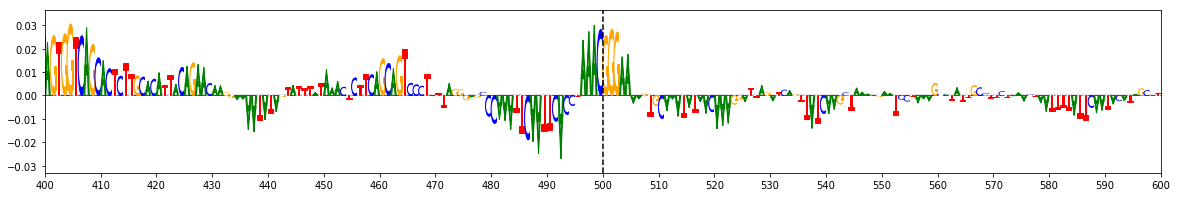

Effect Allele : T   ||   Explain Score : 0.0013   ||   Center / 200bp : 0.0019
Effect Sequence : TCACCTAAATGGGAAAAGTG


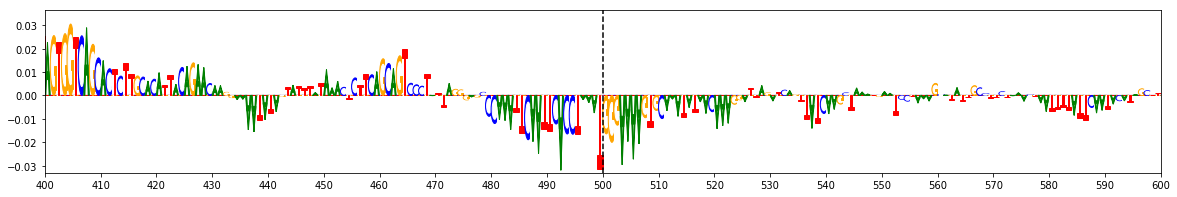

Allele Ratio : 0.0059   ||   Allele Difference : -0.4691  ||  ISM Score : -0.736  ||  deltaSVM Score : -4.1957


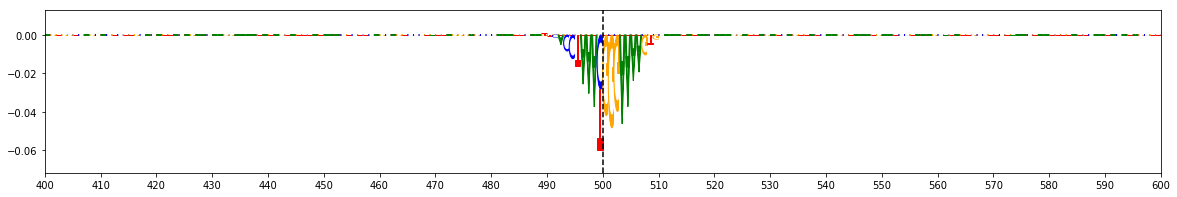


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755951   ||    chr8 : 27369272 - 27369273   ||    Locus: 511   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  1.99E-07
Alzheimers_Jansen_2018 		  1.31E-11
Alzheimers_Kunkle_2019 		  3.79E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.866   ||   Center / 200bp : 0.6537
Noneffect Sequence : TTCACTGGCCTGTAGGGGGA


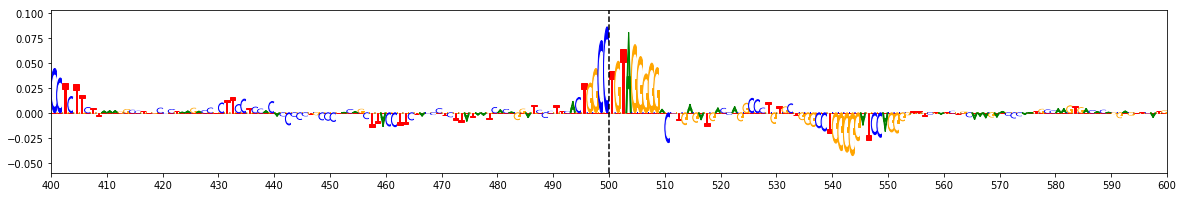

Effect Allele : A   ||   Explain Score : 0.1563   ||   Center / 200bp : 0.2541
Effect Sequence : TTCACTGGCATGTAGGGGGA


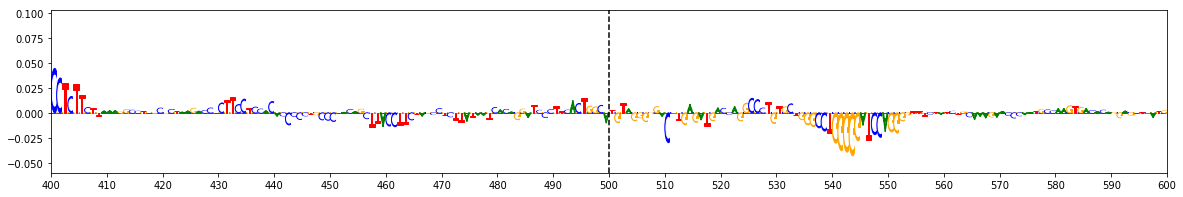

Allele Ratio : 0.1805   ||   Allele Difference : -0.7558  ||  ISM Score : -1.1804  ||  deltaSVM Score : -6.7819


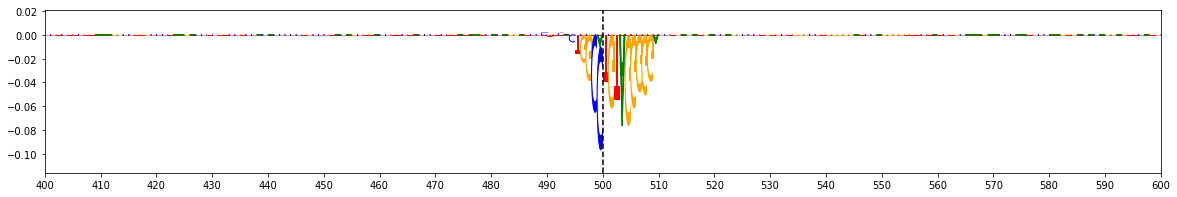


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs636317   ||    chr11 : 60251676 - 60251677   ||    Locus: 39   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  2.83E-13
Alzheimers_Kunkle_2019 		  5.91E-15
Alzheimers_Lambert_2013 	  1.41E-10

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 2.6742   ||   Center / 200bp : 0.7807
Noneffect Sequence : CTTTGCTGCCATCTGCTGGG


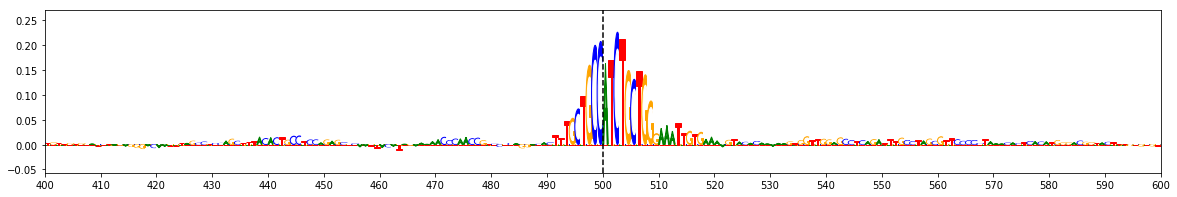

Effect Allele : T   ||   Explain Score : 1.051   ||   Center / 200bp : 0.5831
Effect Sequence : CTTTGCTGCTATCTGCTGGG


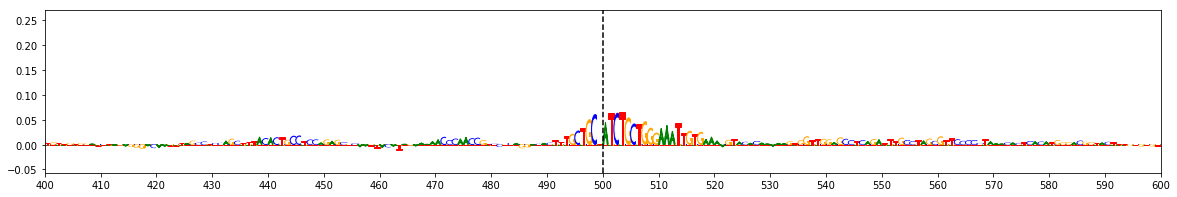

Allele Ratio : 0.393   ||   Allele Difference : -1.6231  ||  ISM Score : -2.5248  ||  deltaSVM Score : -14.5344


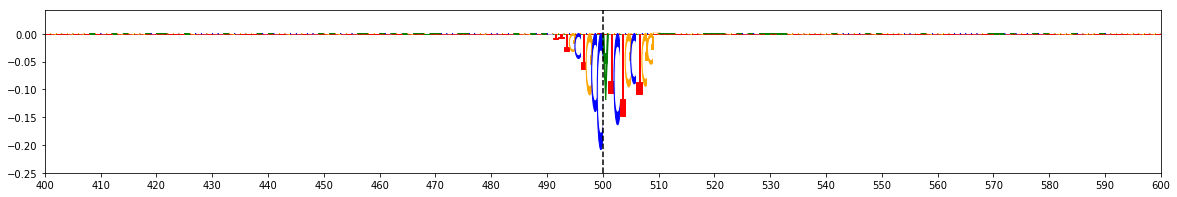


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 239   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.40E-01
Alzheimers_Kunkle_2019 		  1.89E-05
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.9748   ||   Center / 200bp : 0.4943
Noneffect Sequence : GGCCGTCCCCGCCCCGAACC


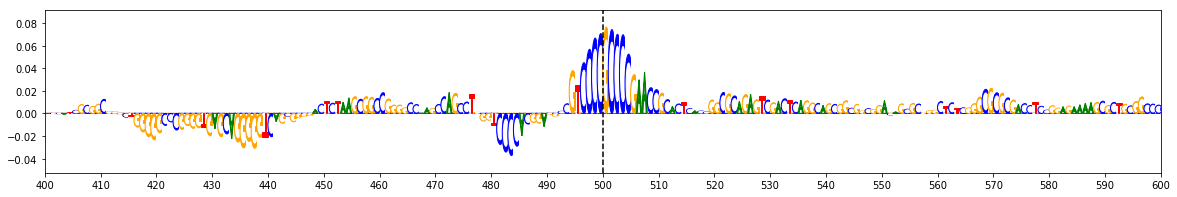

Effect Allele : T   ||   Explain Score : 0.3386   ||   Center / 200bp : 0.2526
Effect Sequence : GGCCGTCCCTGCCCCGAACC


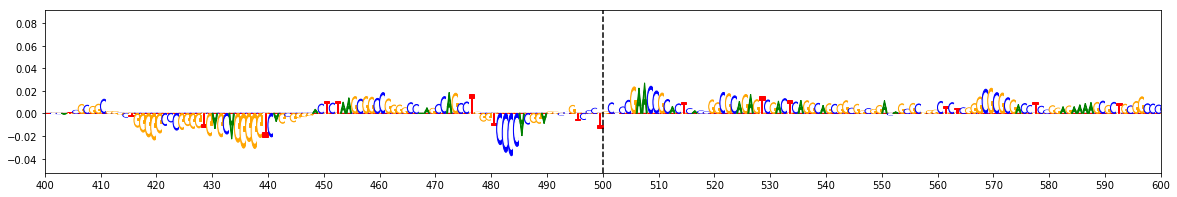

Allele Ratio : 0.3473   ||   Allele Difference : -0.6562  ||  ISM Score : -1.0541  ||  deltaSVM Score : -5.9603


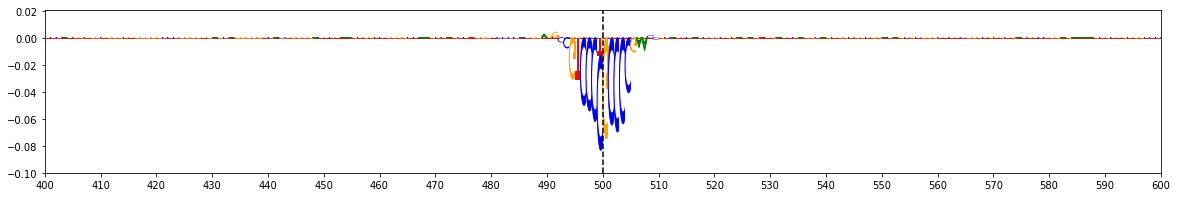


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 358   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.1588   ||   Center / 200bp : 0.5029
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


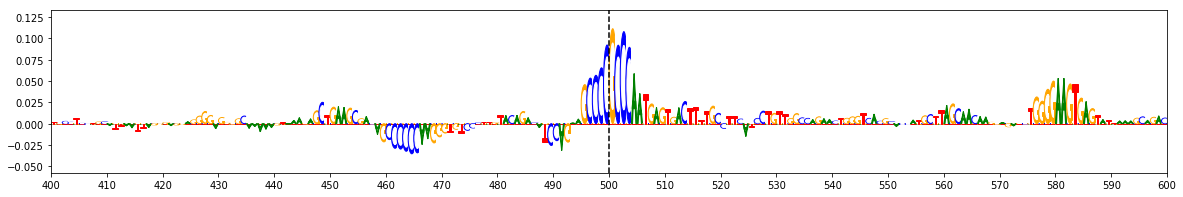

Effect Allele : T   ||   Explain Score : 0.4761   ||   Center / 200bp : 0.2937
Effect Sequence : CAGAAGCCCTGCCCAATGAG


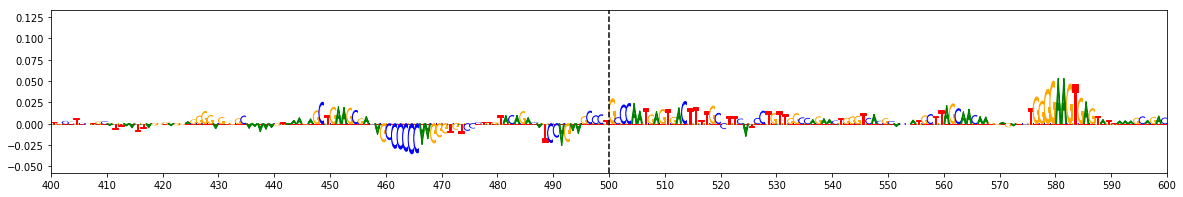

Allele Ratio : 0.4108   ||   Allele Difference : -0.6889  ||  ISM Score : -1.0741  ||  deltaSVM Score : -6.0811


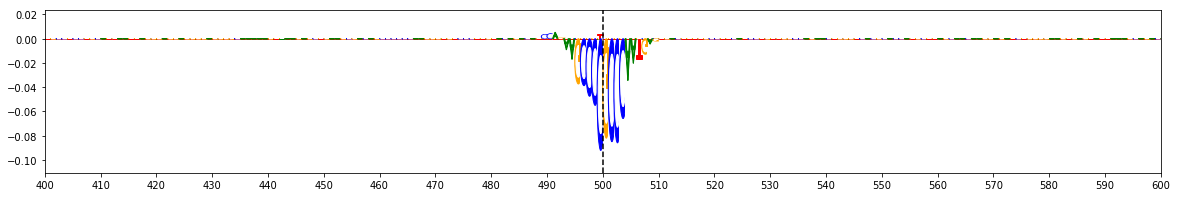


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 458   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.8133   ||   Center / 200bp : 0.4757
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


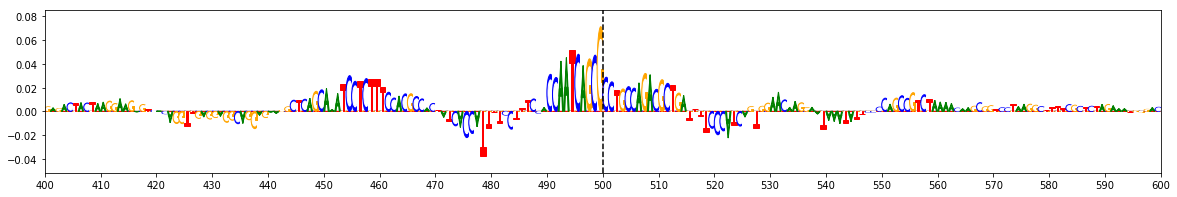

Effect Allele : NAN   ||   Explain Score : 0.3369   ||   Center / 200bp : 0.2716
Effect Sequence : CCAATCAGCCCCTGCCAGAC


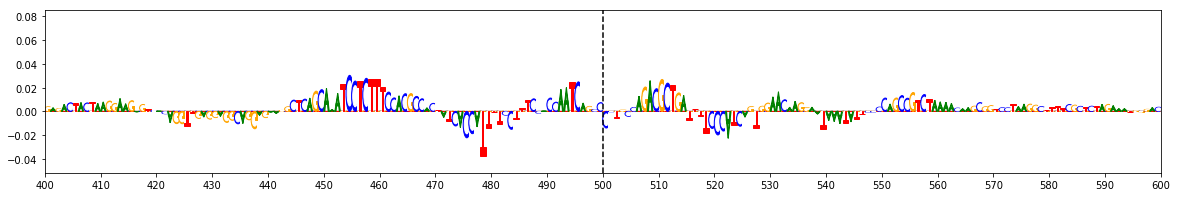

Allele Ratio : 0.4142   ||   Allele Difference : -0.5026  ||  ISM Score : -0.7651  ||  deltaSVM Score : -4.5977


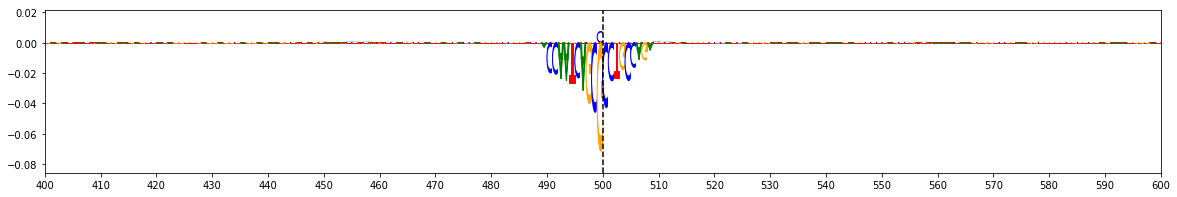


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2737005   ||    chr4 : 89829438 - 89829439   ||    Locus: 446   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.09E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.454   ||   Center / 200bp : 0.6358
Noneffect Sequence : TTCAGCAACACTTCCTCTGG


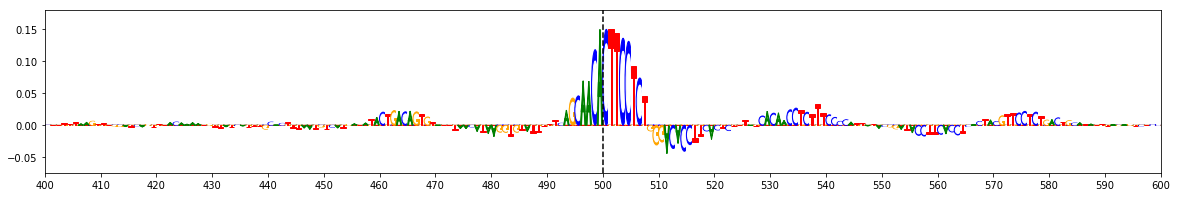

Effect Allele : NAN   ||   Explain Score : 0.8246   ||   Center / 200bp : 0.4973
Effect Sequence : TTCAGCAACGCTTCCTCTGG


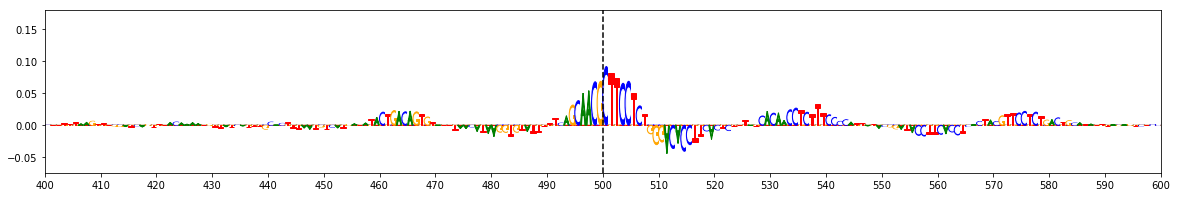

Allele Ratio : 0.5671   ||   Allele Difference : -0.6329  ||  ISM Score : -0.9957  ||  deltaSVM Score : -5.6913


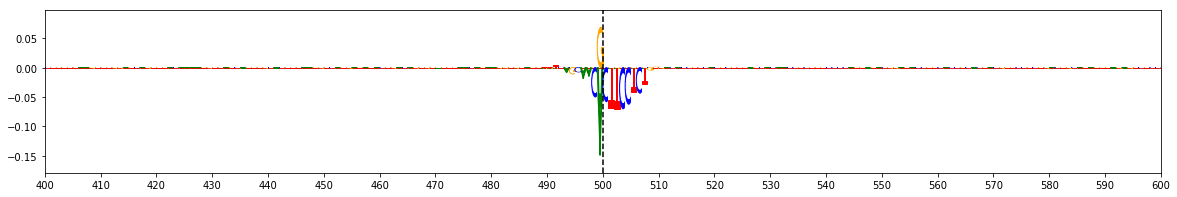


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10409505   ||    chr19 : 18479440 - 18479441   ||    Locus: 243   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.67E-02
Alzheimers_Kunkle_2019 		  3.38E-05
Alzheimers_Lambert_2013 	  5.26E-05

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.072   ||   Center / 200bp : 0.5175
Noneffect Sequence : GGCATGGTAGCTCACACCTG


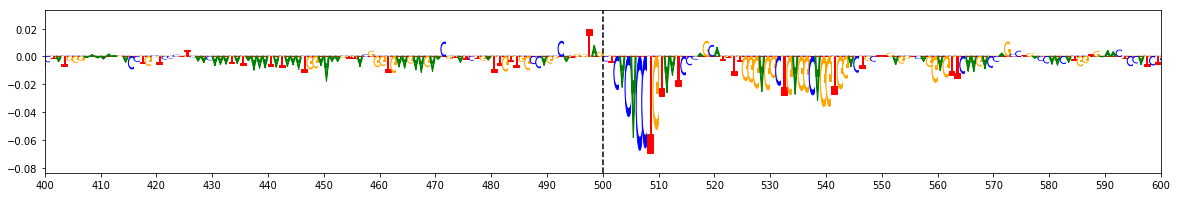

Effect Allele : C   ||   Explain Score : 0.0339   ||   Center / 200bp : 0.3356
Effect Sequence : GGCATGGTACCTCACACCTG


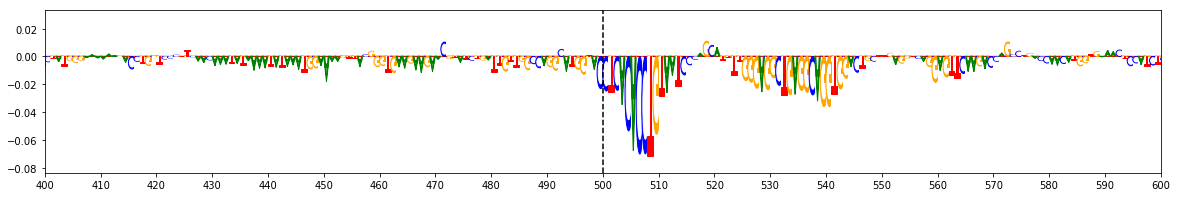

Allele Ratio : 0.4713   ||   Allele Difference : -0.2056  ||  ISM Score : -0.3239  ||  deltaSVM Score : -1.8648


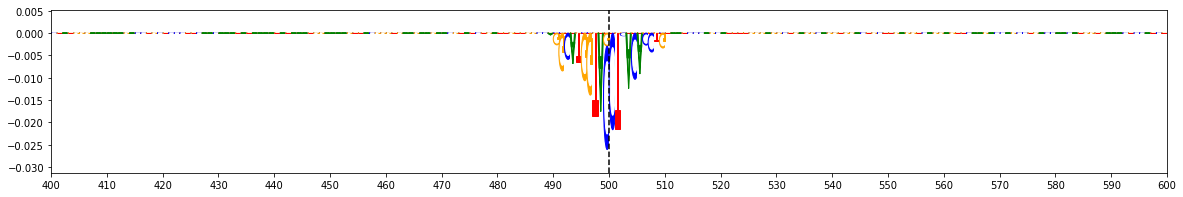


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10130373   ||    chr14 : 92466230 - 92466231   ||    Locus: 119   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  6.16E-09

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 2.8207   ||   Center / 200bp : 0.6718
Noneffect Sequence : CTCAGCAAGAGGAAGTTAAC


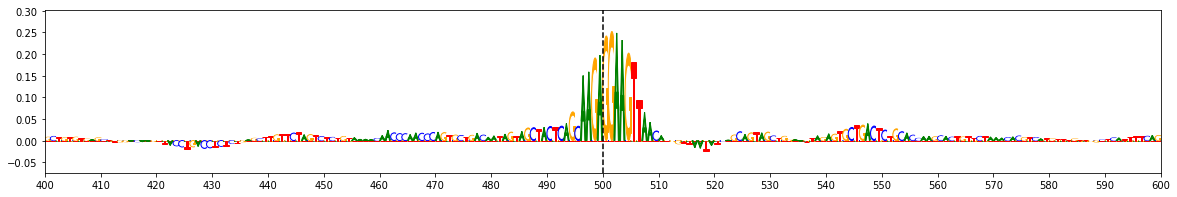

Effect Allele : C   ||   Explain Score : 1.9139   ||   Center / 200bp : 0.5813
Effect Sequence : CTCAGCAAGCGGAAGTTAAC


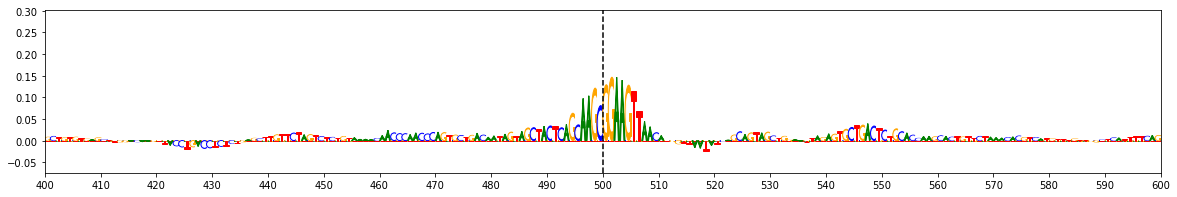

Allele Ratio : 0.6785   ||   Allele Difference : -0.9068  ||  ISM Score : -1.4113  ||  deltaSVM Score : -8.0676


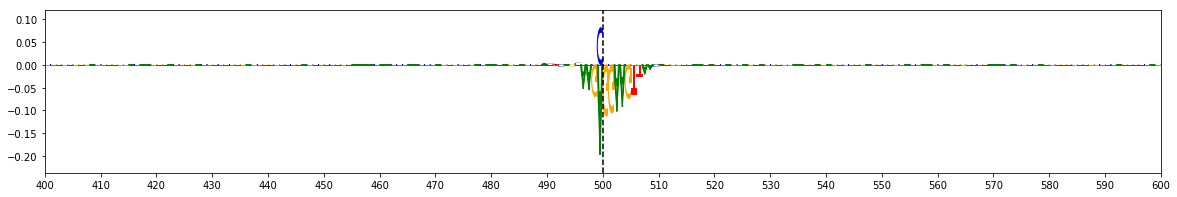


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6658353   ||    chr1 : 161499263 - 161499264   ||    Locus: 7   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.97E-02

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.7258   ||   Center / 200bp : 0.565
Noneffect Sequence : CAGAGTCTTCCTCTGTTACT


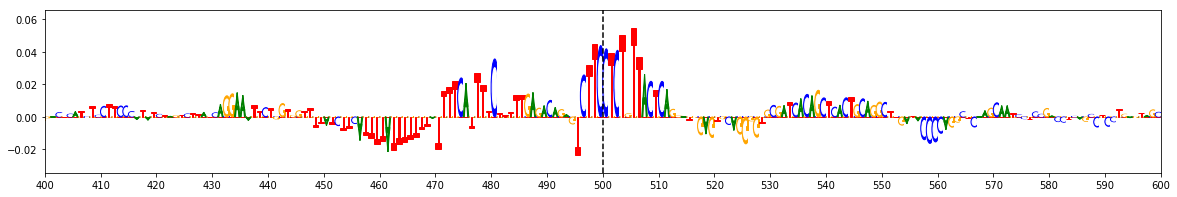

Effect Allele : G   ||   Explain Score : 0.4342   ||   Center / 200bp : 0.4374
Effect Sequence : CAGAGTCTTGCTCTGTTACT


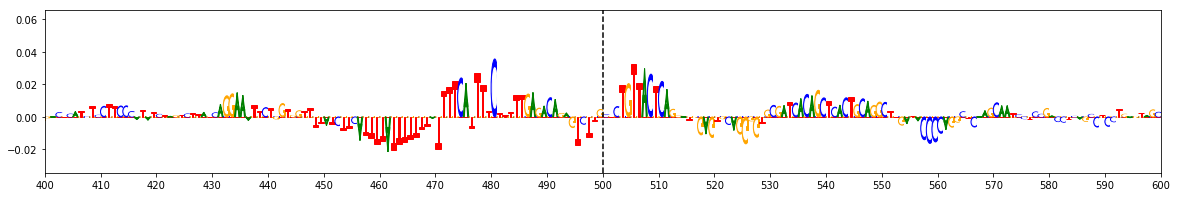

Allele Ratio : 0.5983   ||   Allele Difference : -0.3074  ||  ISM Score : -0.4941  ||  deltaSVM Score : -2.7652


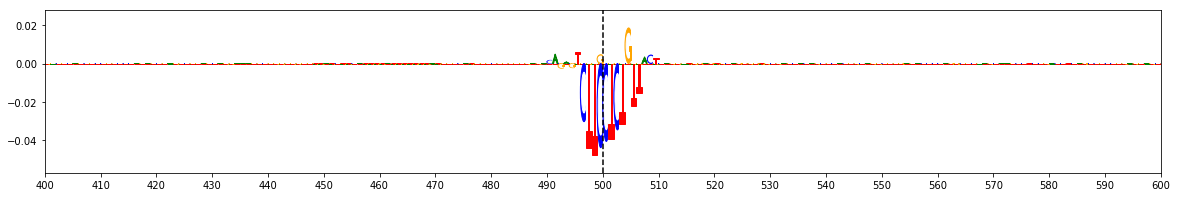


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4680406   ||    chr3 : 151399027 - 151399028   ||    Locus: 425   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.14E-05

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 4.5405   ||   Center / 200bp : 0.7985
Noneffect Sequence : AGTGAAACCACAGAGAAGTG


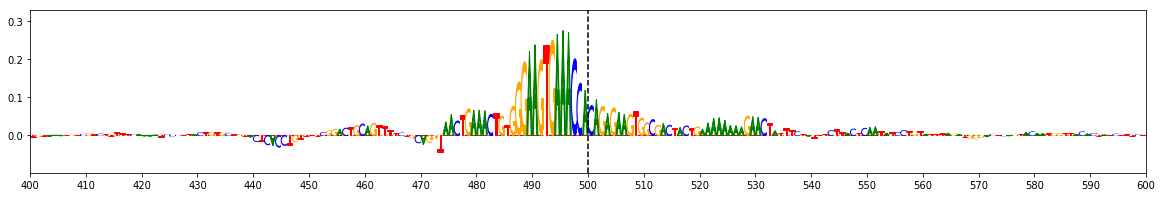

Effect Allele : G   ||   Explain Score : 3.9826   ||   Center / 200bp : 0.7764
Effect Sequence : AGTGAAACCGCAGAGAAGTG


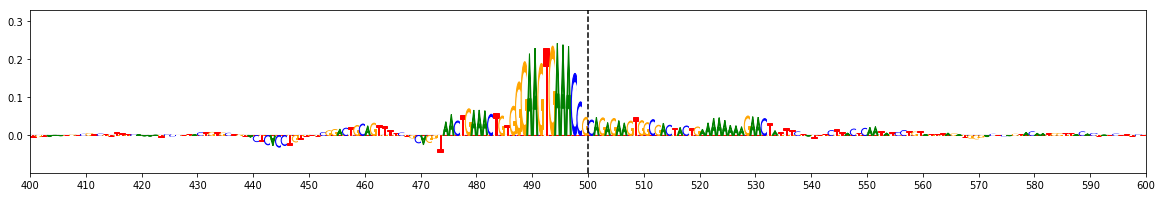

Allele Ratio : 0.8771   ||   Allele Difference : -0.5579  ||  ISM Score : -0.8863  ||  deltaSVM Score : -5.1244


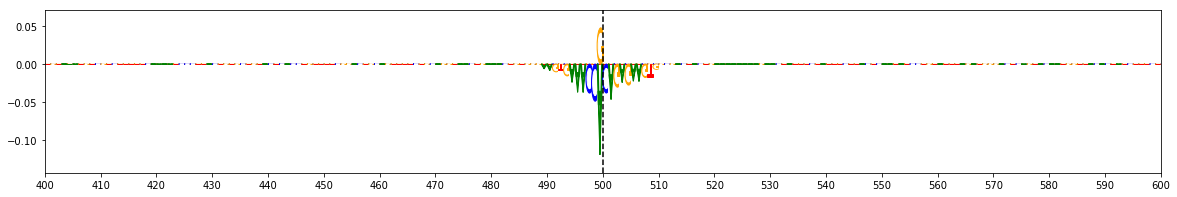


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55827552   ||    chr17 : 75088242 - 75088243   ||    Locus: 222   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.87E-03
Alzheimers_Lambert_2013 	  8.30E-03

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.5748   ||   Center / 200bp : 0.4081
Noneffect Sequence : CGCAAGCCCGAGGGCGCTCG


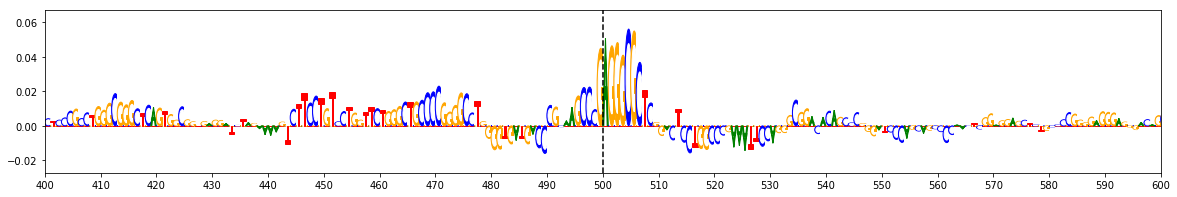

Effect Allele : A   ||   Explain Score : 0.2582   ||   Center / 200bp : 0.2361
Effect Sequence : CGCAAGCCCAAGGGCGCTCG


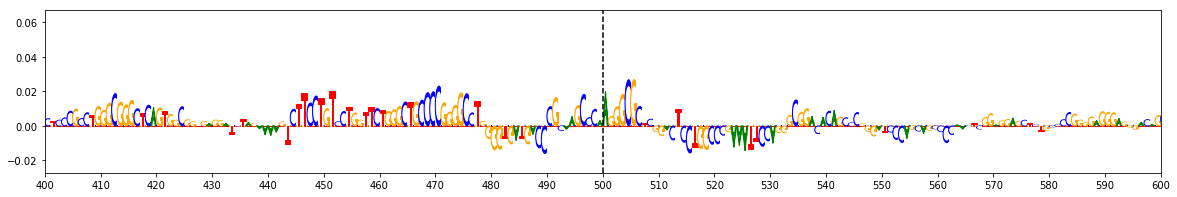

Allele Ratio : 0.4492   ||   Allele Difference : -0.3248  ||  ISM Score : -0.5141  ||  deltaSVM Score : -2.9866


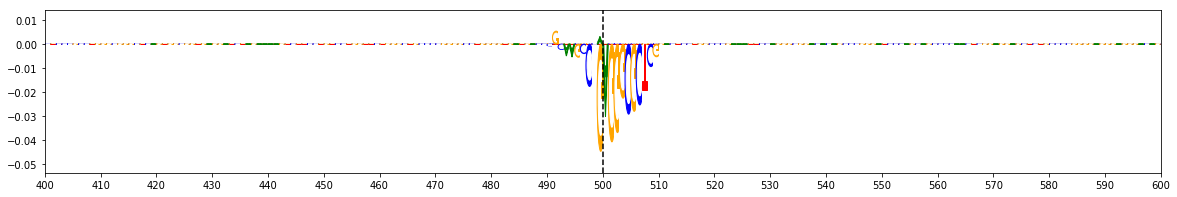


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 240   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  7.31E-02
Alzheimers_Kunkle_2019 		  1.28E-05
Alzheimers_Lambert_2013 	  3.29E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.9266   ||   Center / 200bp : 0.6679
Noneffect Sequence : GACCAAGAGCGCCACCTGCT


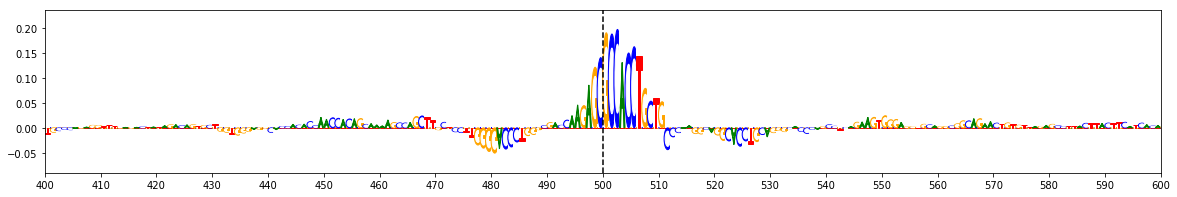

Effect Allele : T   ||   Explain Score : 1.4333   ||   Center / 200bp : 0.5995
Effect Sequence : GACCAAGAGTGCCACCTGCT


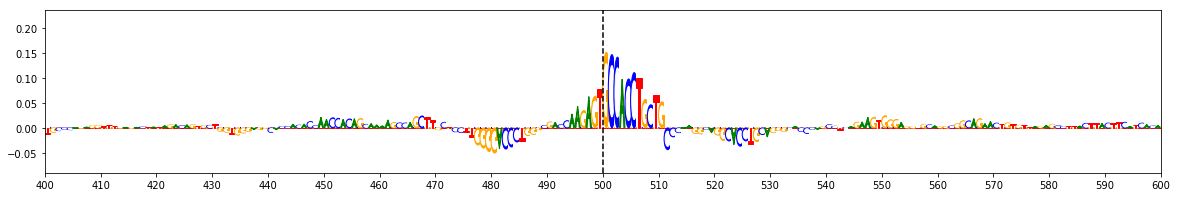

Allele Ratio : 0.7439   ||   Allele Difference : -0.4929  ||  ISM Score : -0.8102  ||  deltaSVM Score : -4.6154


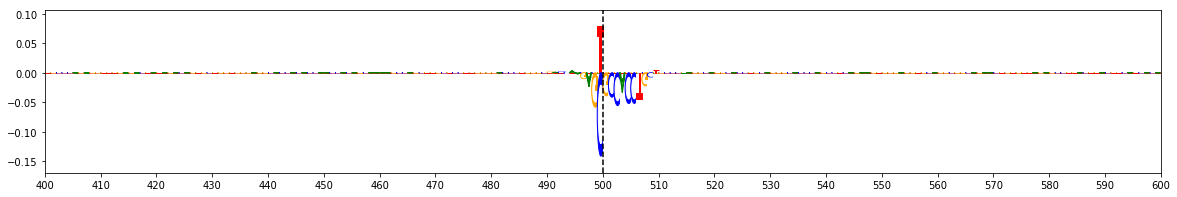


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7248162   ||    chr19 : 44951428 - 44951429   ||    Locus: 314   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.39E-10
Alzheimers_Kunkle_2019 		  1.14E-13
Alzheimers_Lambert_2013 	  5.51E-11

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.4268   ||   Center / 200bp : 0.3989
Noneffect Sequence : GCTGCCAAGCGCAGGGGGTG


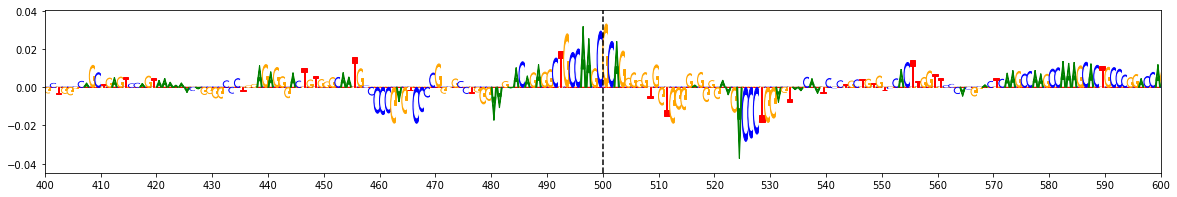

Effect Allele : T   ||   Explain Score : 0.1902   ||   Center / 200bp : 0.2282
Effect Sequence : GCTGCCAAGTGCAGGGGGTG


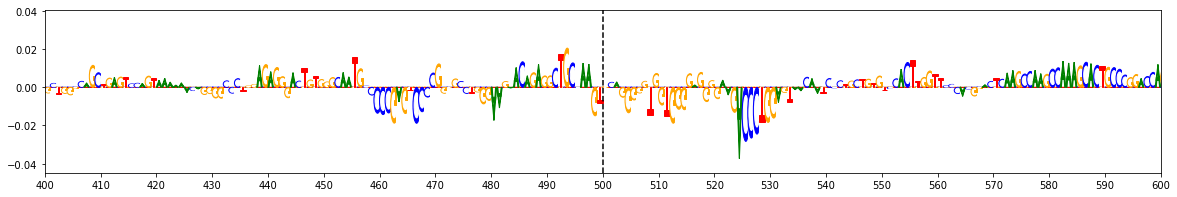

Allele Ratio : 0.4457   ||   Allele Difference : -0.2966  ||  ISM Score : -0.4674  ||  deltaSVM Score : -2.6804


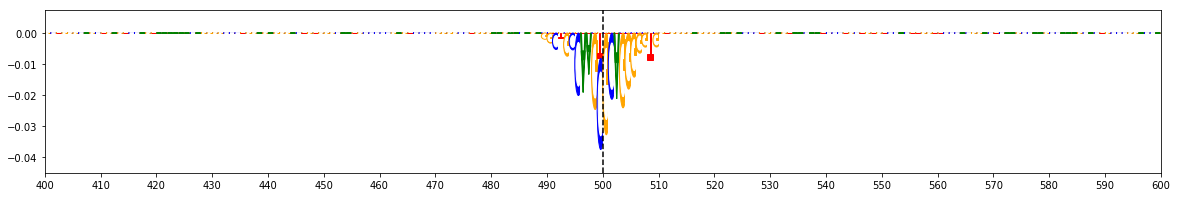


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2149482   ||    chr14 : 54901908 - 54901909   ||    Locus: 97   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.27E-07
Nalls_23andMe 		  1.27E-07

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.4246   ||   Center / 200bp : 0.7263
Noneffect Sequence : GGAACTACCCAGGAAGCCGT


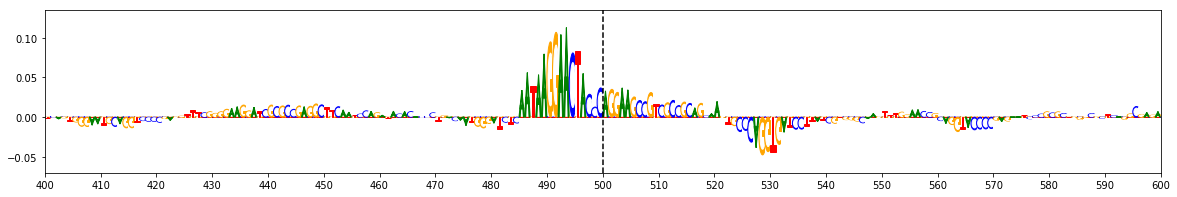

Effect Allele : T   ||   Explain Score : 1.1695   ||   Center / 200bp : 0.685
Effect Sequence : GGAACTACCTAGGAAGCCGT


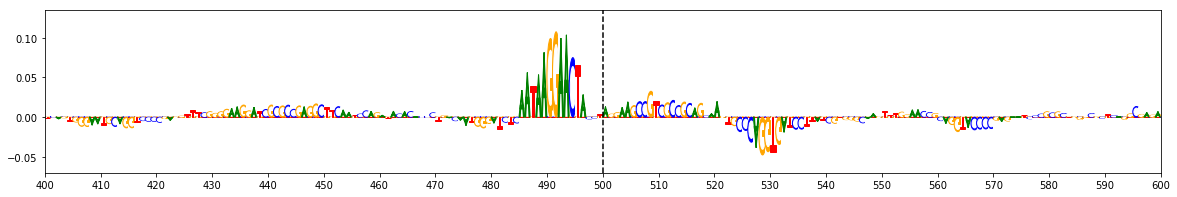

Allele Ratio : 0.8209   ||   Allele Difference : -0.2589  ||  ISM Score : -0.4122  ||  deltaSVM Score : -2.3063


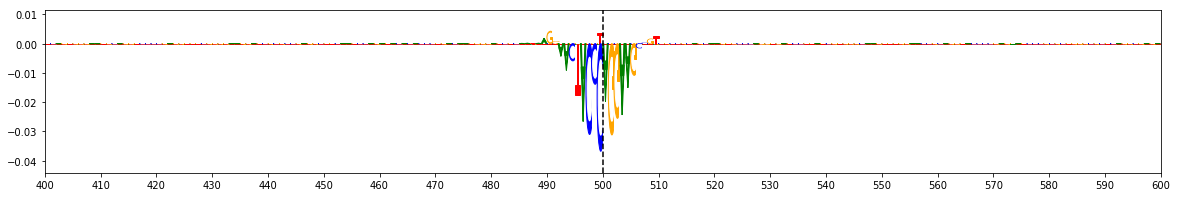


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 250   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.8171   ||   Center / 200bp : 0.4702
Noneffect Sequence : CAACACGGGGCGGGCACAAG


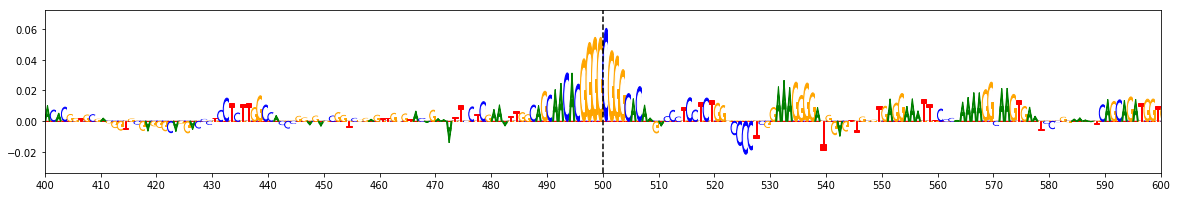

Effect Allele : T   ||   Explain Score : 0.4349   ||   Center / 200bp : 0.3203
Effect Sequence : CAACACGGGTCGGGCACAAG


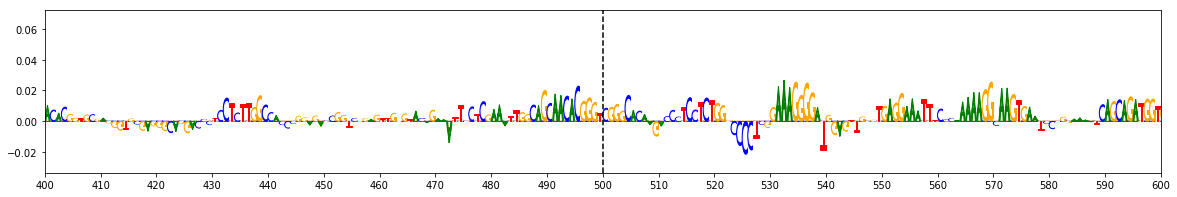

Allele Ratio : 0.5322   ||   Allele Difference : -0.3866  ||  ISM Score : -0.6179  ||  deltaSVM Score : -3.5446


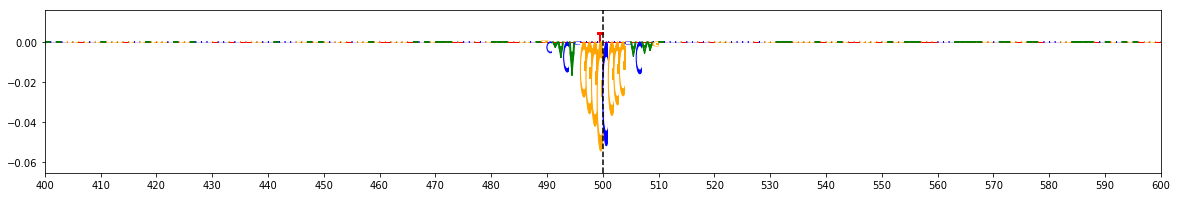


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2250583   ||    chr15 : 58758182 - 58758183   ||    Locus: 121   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  8.26E-09

Coloc:  False

Noneffect Allele : T   ||   Explain Score : 0.471   ||   Center / 200bp : 0.6414
Noneffect Sequence : ATGAGCCATTGAGCCTGGCC


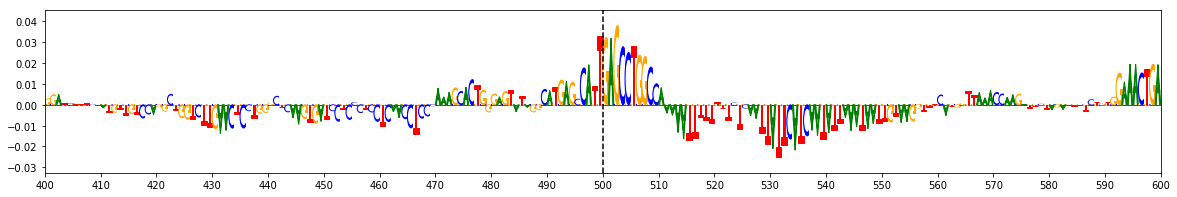

Effect Allele : C   ||   Explain Score : 0.3421   ||   Center / 200bp : 0.565
Effect Sequence : ATGAGCCATCGAGCCTGGCC


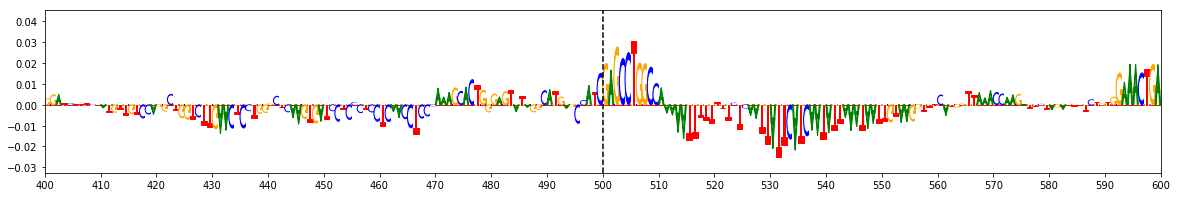

Allele Ratio : 0.7263   ||   Allele Difference : -0.1405  ||  ISM Score : -0.2266  ||  deltaSVM Score : -1.3582


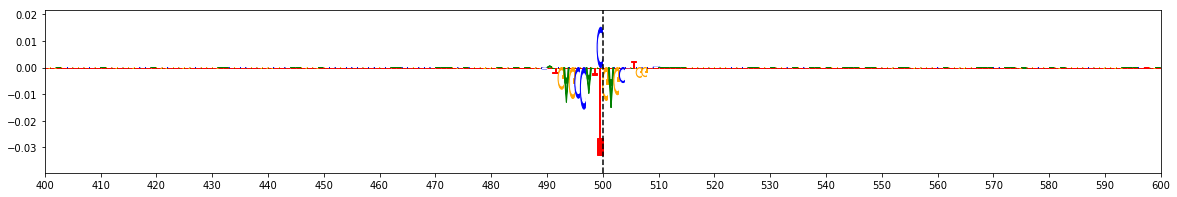


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2526377   ||    chr17 : 58332679 - 58332680   ||    Locus: 207   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.13E-07
Alzheimers_Kunkle_2019 		  1.95E-06
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.4546   ||   Center / 200bp : 0.5583
Noneffect Sequence : GGAAACAGAAGGGGGTGGGC


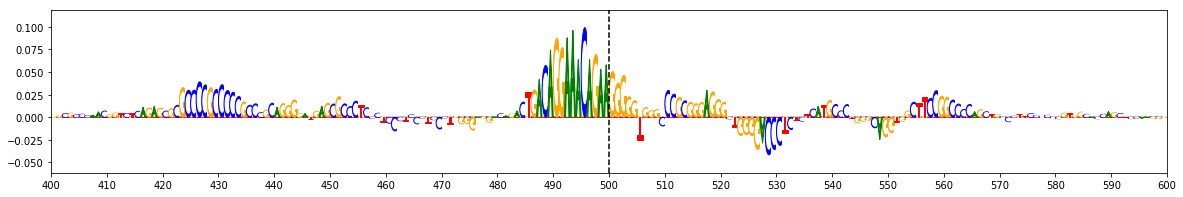

Effect Allele : NAN   ||   Explain Score : 0.9202   ||   Center / 200bp : 0.4449
Effect Sequence : GGAAACAGAGGGGGGTGGGC


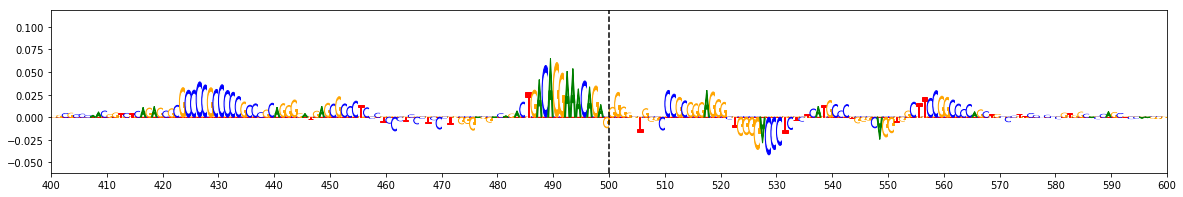

Allele Ratio : 0.6326   ||   Allele Difference : -0.5498  ||  ISM Score : -0.9148  ||  deltaSVM Score : -5.3633


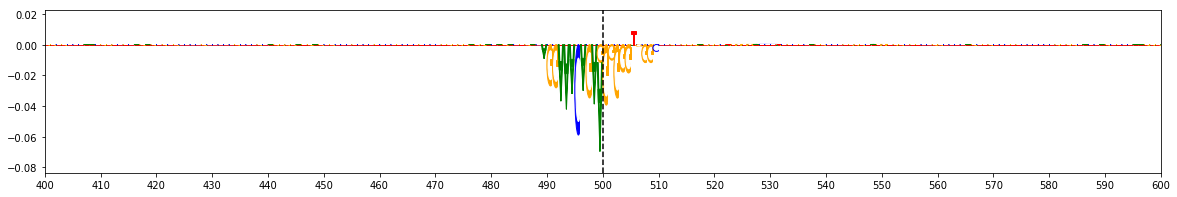


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 182   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.6573   ||   Center / 200bp : 0.6284
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


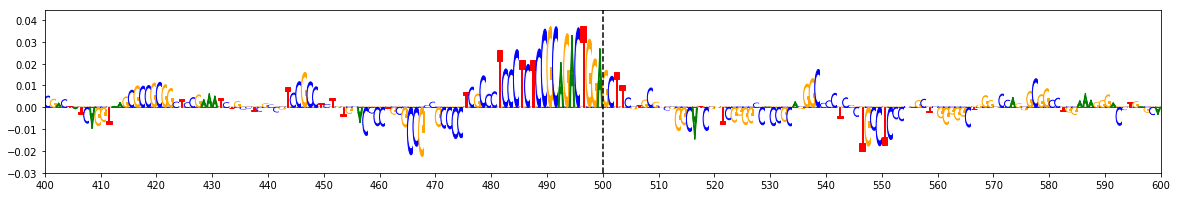

Effect Allele : G   ||   Explain Score : 0.4722   ||   Center / 200bp : 0.5487
Effect Sequence : GCAGACTGGGGCTTCGTGCG


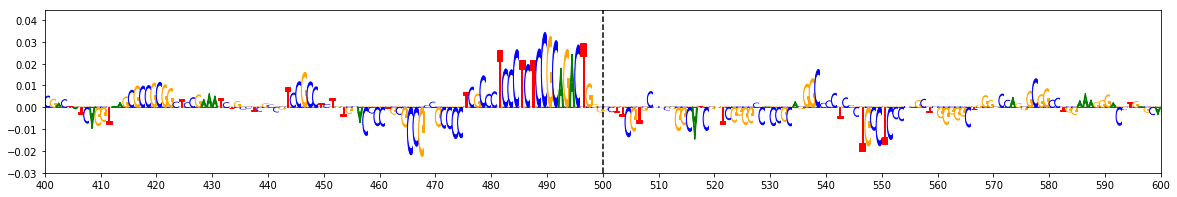

Allele Ratio : 0.7184   ||   Allele Difference : -0.2295  ||  ISM Score : -0.3685  ||  deltaSVM Score : -2.1103


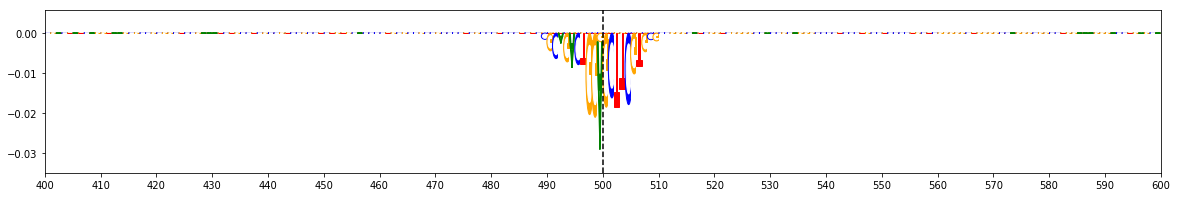


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs421812   ||    chr19 : 44877287 - 44877288   ||    Locus: 289   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.31E-06
Alzheimers_Kunkle_2019 		  2.10E-02
Alzheimers_Lambert_2013 	  1.24E-02

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.2489   ||   Center / 200bp : 0.7525
Noneffect Sequence : GCCTTGCATGCAGGGATGGG


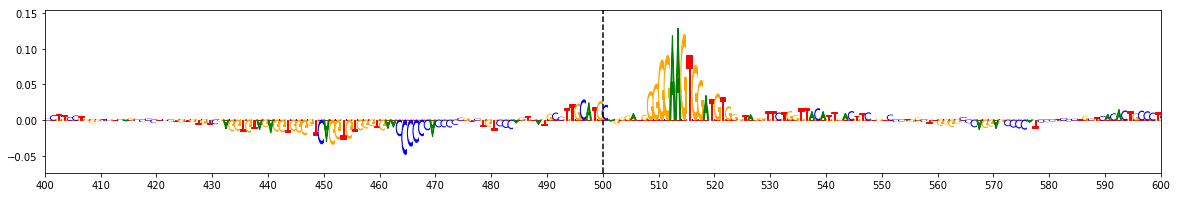

Effect Allele : T   ||   Explain Score : 1.0829   ||   Center / 200bp : 0.7236
Effect Sequence : GCCTTGCATTCAGGGATGGG


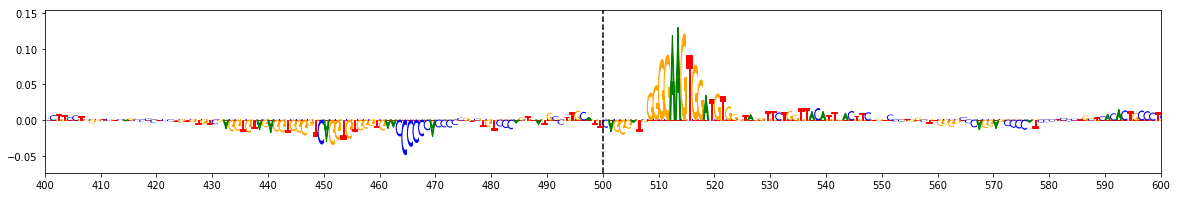

Allele Ratio : 0.8671   ||   Allele Difference : -0.2747  ||  ISM Score : -0.4265  ||  deltaSVM Score : -2.5833


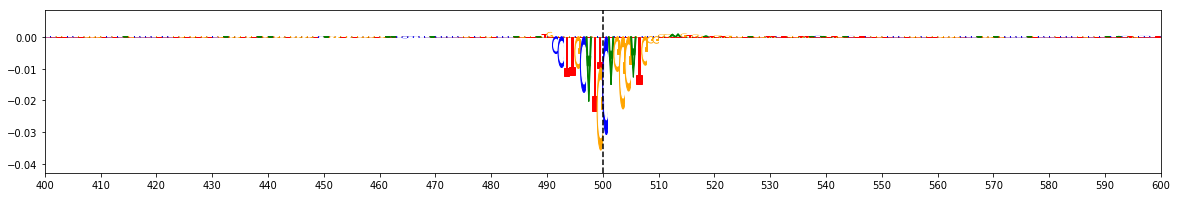


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref    alt  \
503   chr8   16837908   16837909    rs1717289      T         C   C      T   
390   chr2  134782975  134782976    rs7599054      G         A   A    G,T   
415   chr3   52498433   52498434  rs181391313      G         A   G      A   
329  chr19   45039212   45039213   rs34034621      T         C   C      T   
509   chr8   22604860   22604861    rs3735901      T         C   T      C   
2     chr1   39890482   39890483    rs6684490      A         G   A      G   
295  chr19   44905370   44905371     rs769446      T         C   T      C   
359   chr2  127128656  127128657   rs13025765      T         C   C      T   
283  chr19   44856328   44856329   rs56317818      T         C   C    G,T   
93   chr12   40224294   40224295    rs1388597      G         A   A      G   
433   chr4     987143     987144   rs10902762      G         A   G      A   
437   chr4   76242272   76242273   rs12643198      G         A   G      A   
357   chr2  127120861  127120862    rs4663100      C         G   C      G   
40   chr11   60251687   60251688     rs636341      A         C   A      C   
251  chr19   44713380   44713381   rs58522314      G         A   A      G   
83   chr11   86156832   86156833   rs10792832      A         G   A      G   
198  chr17   46192692   46192693    rs2696633      T         A   A      T   
164  chr17   45411425   45411426   rs62064641      T         C   T      C   
9     chr1  171741264  171741265    rs2298914      T         C   C      T   
22   chr11   47378050   47378051    rs2278890      A         G   G      A   
71   chr11   86021646   86021647    rs1949221      G         A   A    C,G   
391   chr2  168247488  168247489   rs76179989      T         G   T      G   
317  chr19   44951508   44951509    rs7247551      A         G   G      A   
42   chr11   60252638   60252639     rs672399      T         G   T    A,G   
387   chr2  134719264  134719265   rs62171395      G         C   C      G   
190  chr17   46004160   46004161   rs62064665      T         C   T      C   
474   chr6   27772520   27772521     rs760587      C         A   C      A   
16   chr10   80505514   80505515    rs9633740      A         G   A      G   
67   chr11   65889092   65889093    rs2231884      T         C   C      T   
158  chr17    5255418    5255419   rs61481506      C         T   T      C   
..     ...        ...        ...          ...    ...       ...  ..    ...   
163  chr17   45411015   45411016    rs8071011      T         C   C      T   
410   chr3   52288193   52288194  rs146664705      G         C   C    A,G   
92   chr12   40223889   40223890   rs10878226      G         C   G    A,C   
330  chr19   45040496   45040497   rs76856627      G         A   A      G   
6     chr1  161186242  161186243   rs11585858      A         C   C    A,G   
426   chr3  161334004  161334005   rs11718905      G         A   G      A   
184  chr17   45949123   45949124   rs77266933      C         A   A      C   
165  chr17   45413486   45413487   rs62064643      G         A   G      A   
140  chr17    4858616    4858617    rs8067447      T         C   C      T   
176  chr17   45873978   45873979   rs62055492      C         A   C    A,T   
312  chr19   44947150   44947151    rs9304646      C         T   T  A,C,G   
41   chr11   60251787   60251788    rs3041800      G       GTA   G    GTA   
168  chr17   45425917   45425918   rs76344126      G         A   G      A   
62   chr11   60333979   60333980   rs10750935      C         T   T    C,G   
469   chr5  103224361  103224362     rs152137      T         C   C      T   
185  chr17   45949128   45949129   rs74531363      G         A   A    G,T   
287  chr19   44856448   44856449   rs12462573      A         G   G      A   
46   chr11   60263925   60263926   rs10736700      T         C   T    A,C   
327  chr19   45001268   45001269  rs117612135      T         C   C      T   
172  chr17   45584384   45584385    rs2693359      T         A   T      A   
36 

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs1717289   ||    chr8 : 16837908 - 16837909   ||    Locus: 503   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.22E-04
Nalls_23andMe 		  2.22E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.3808   ||  Center / 200bp: 0.6001
Effect Sequence: GTTTTTCAGTTCCTGGTGGT


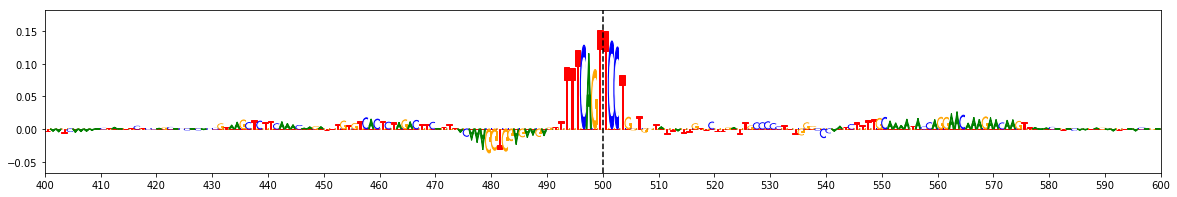

Noneffect Allele: C   ||  Explain Score: 0.1026   ||  Center / 200bp: 0.1001
Noneffect Sequence: GTTTTTCAGCTCCTGGTGGT


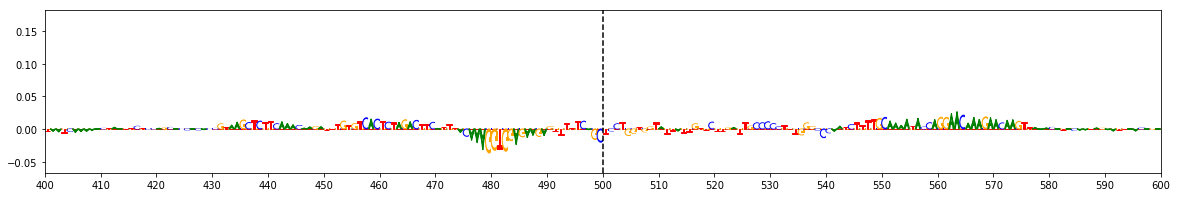

Allele Ratio : 13.4558   ||   Allele Difference : 1.355  ||  ISM Score : 2.1261  ||  deltaSVM Score : 12.1979


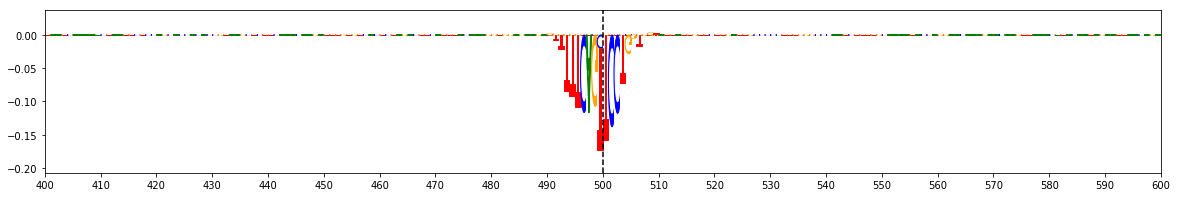


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7599054   ||    chr2 : 134782975 - 134782976   ||    Locus: 390   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.58E-06

Coloc:  False

Effect Allele: G   ||  Explain Score: 2.8254   ||  Center / 200bp: 0.6921
Effect Sequence: CACTAGGGGGCAATATCCAT


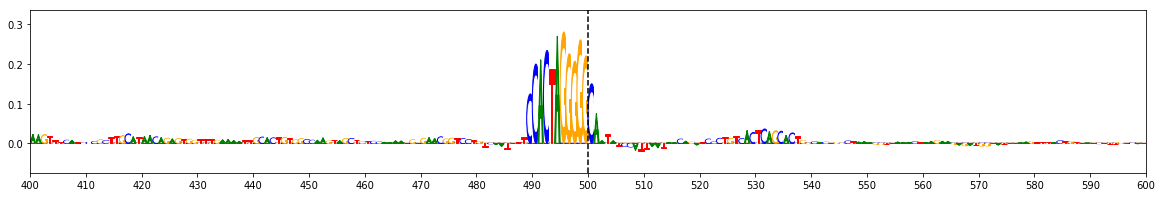

Noneffect Allele: A   ||  Explain Score: 1.1273   ||  Center / 200bp: 0.4733
Noneffect Sequence: CACTAGGGGACAATATCCAT


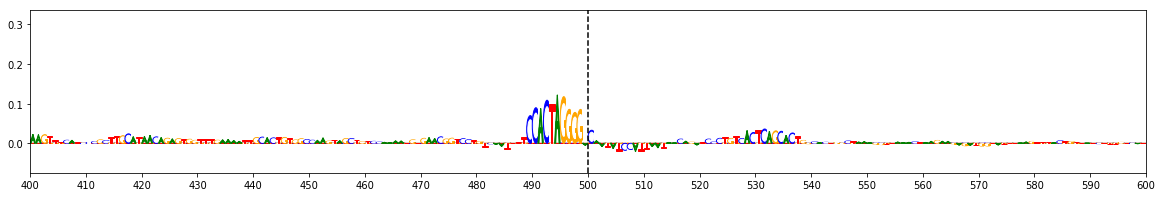

Allele Ratio : 2.5063   ||   Allele Difference : 1.7683  ||  ISM Score : 2.7607  ||  deltaSVM Score : 16.2114


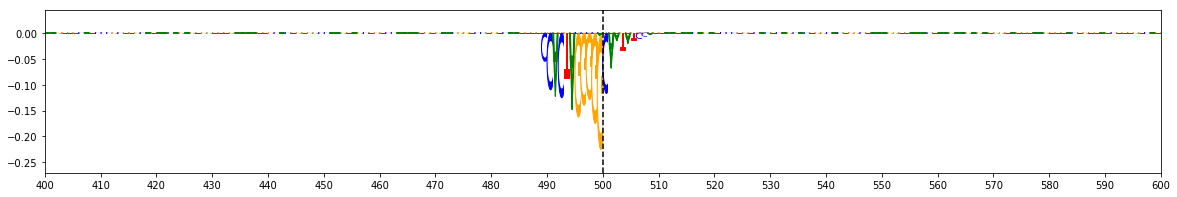


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 415   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.73E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4995   ||  Center / 200bp: 0.3706
Effect Sequence: CCATGGGGCGGAGGCAGGGC


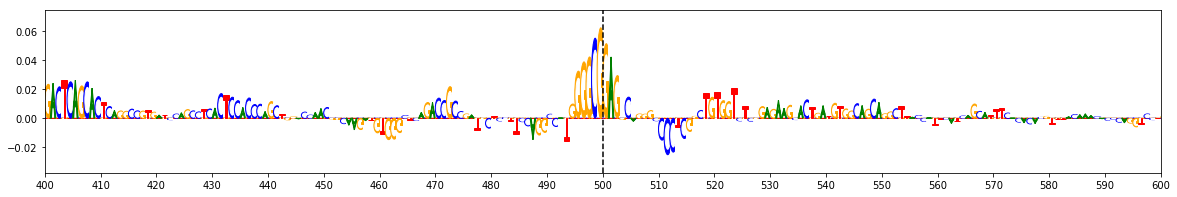

Noneffect Allele: A   ||  Explain Score: 0.1267   ||  Center / 200bp: 0.13
Noneffect Sequence: CCATGGGGCAGAGGCAGGGC


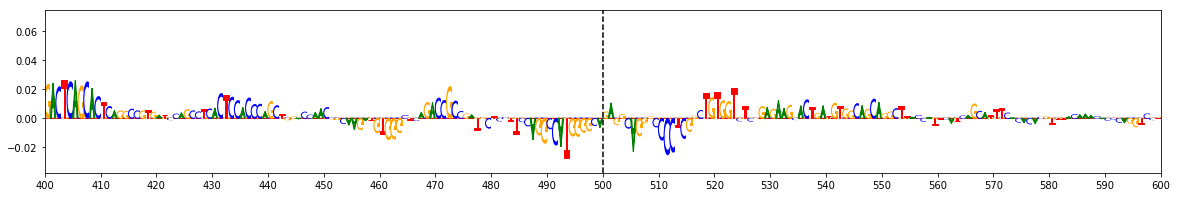

Allele Ratio : 3.9406   ||   Allele Difference : 0.5365  ||  ISM Score : 0.8391  ||  deltaSVM Score : 4.8426


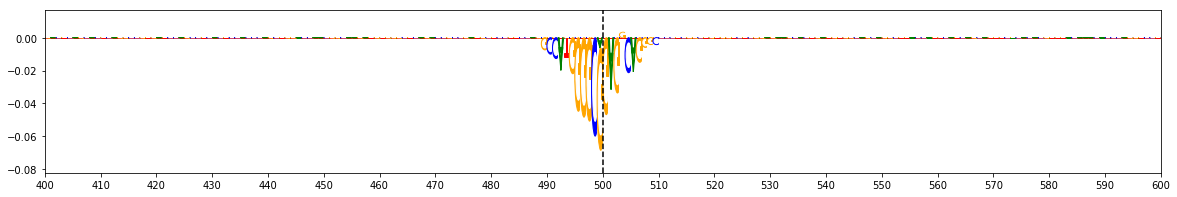


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 329   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5535   ||  Center / 200bp: 0.4553
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


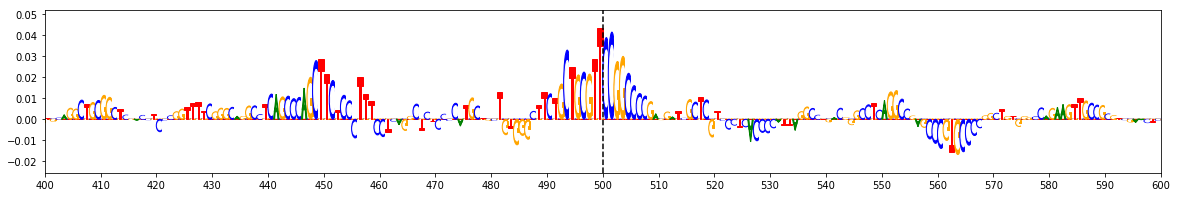

Noneffect Allele: C   ||  Explain Score: 0.2499   ||  Center / 200bp: 0.2742
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


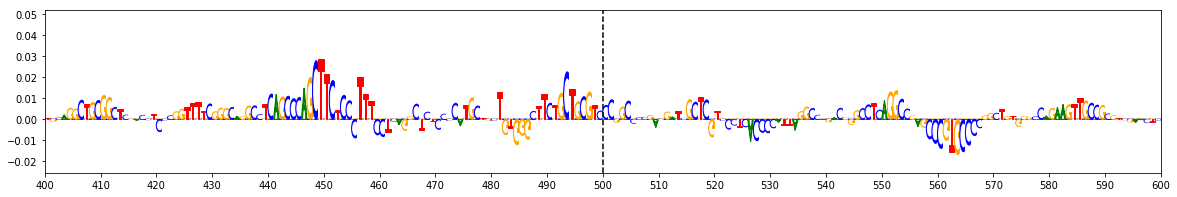

Allele Ratio : 2.215   ||   Allele Difference : 0.3108  ||  ISM Score : 0.4917  ||  deltaSVM Score : 2.8326


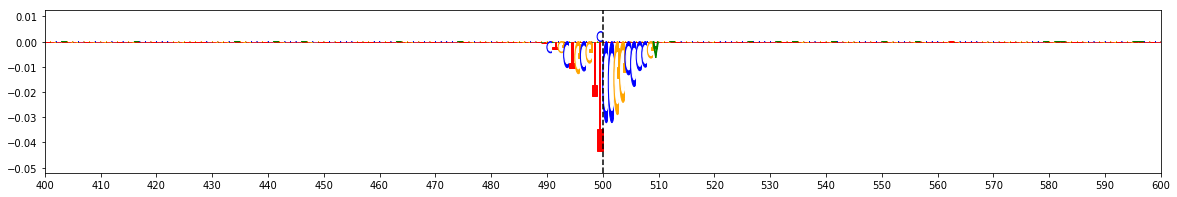


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 509   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.08E-02
Nalls_23andMe 		  5.08E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.3074   ||  Center / 200bp: 0.1952
Effect Sequence: GGGGCCCCCTGCCGCCCCTC


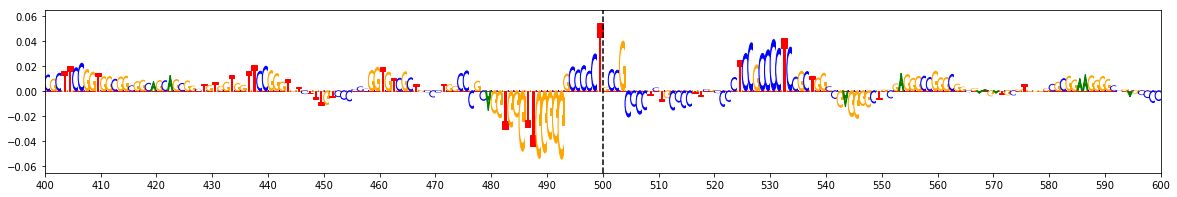

Noneffect Allele: C   ||  Explain Score: 0.0626   ||  Center / 200bp: 0.0484
Noneffect Sequence: GGGGCCCCCCGCCGCCCCTC


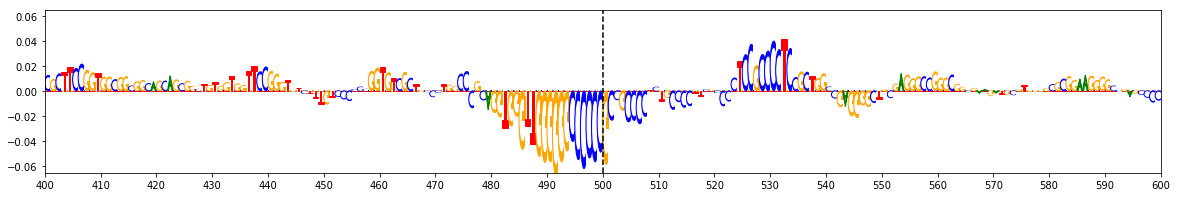

Allele Ratio : 4.9135   ||   Allele Difference : 0.7828  ||  ISM Score : 1.2406  ||  deltaSVM Score : 7.9585


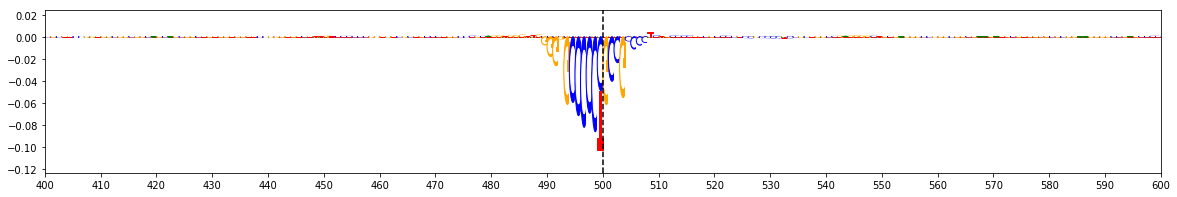


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6684490   ||    chr1 : 39890482 - 39890483   ||    Locus: 2   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.54E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 3.0157   ||  Center / 200bp: 0.746
Effect Sequence: GACTTCCCTATTTCAAAGAG


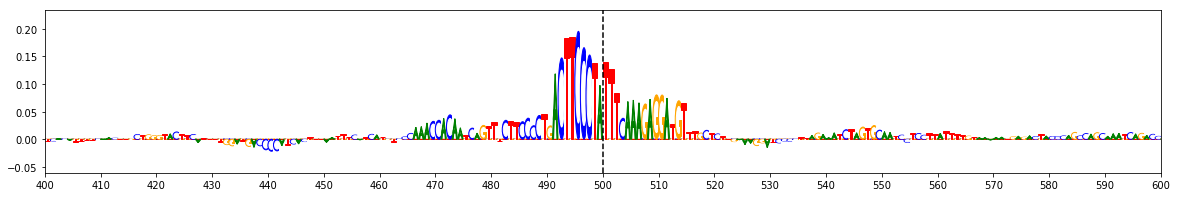

Noneffect Allele: G   ||  Explain Score: 2.4528   ||  Center / 200bp: 0.7048
Noneffect Sequence: GACTTCCCTGTTTCAAAGAG


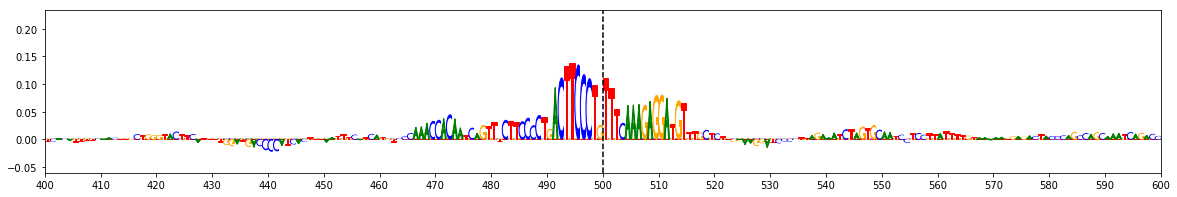

Allele Ratio : 1.2295   ||   Allele Difference : 0.5629  ||  ISM Score : 0.8816  ||  deltaSVM Score : 5.1532


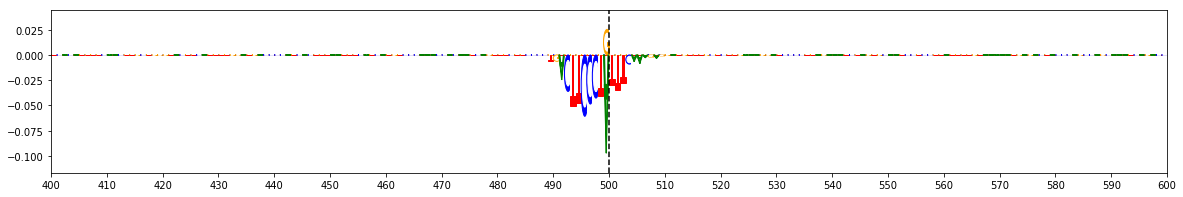


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs769446   ||    chr19 : 44905370 - 44905371   ||    Locus: 295   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.13E-09

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4051   ||  Center / 200bp: 0.5515
Effect Sequence: GGCGTGAGCTACCGCCCCCA


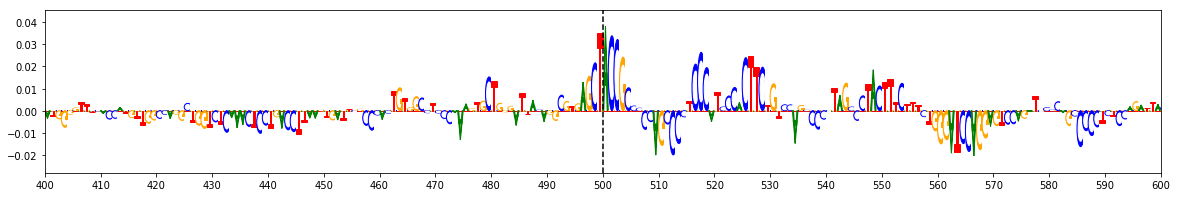

Noneffect Allele: C   ||  Explain Score: 0.255   ||  Center / 200bp: 0.4366
Noneffect Sequence: GGCGTGAGCCACCGCCCCCA


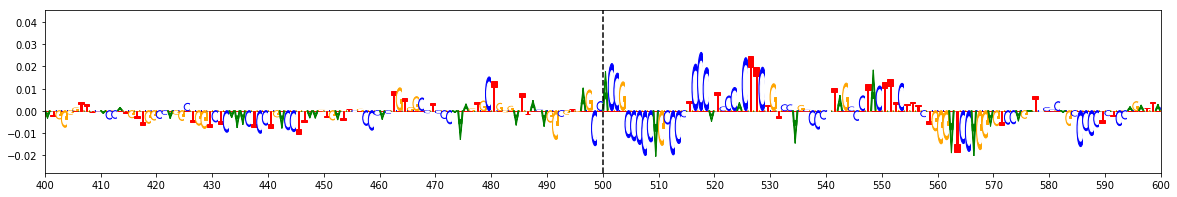

Allele Ratio : 1.5885   ||   Allele Difference : 0.2474  ||  ISM Score : 0.3926  ||  deltaSVM Score : 2.2844


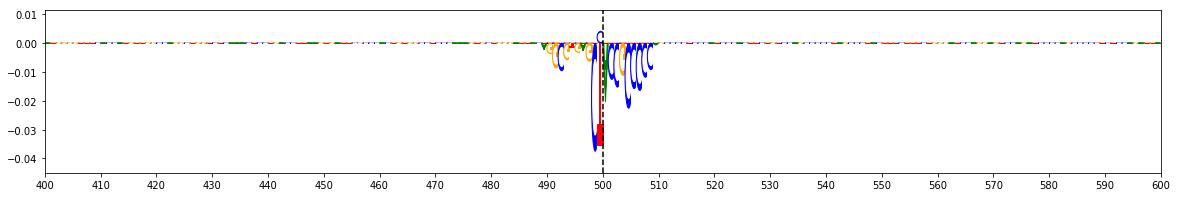


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs13025765   ||    chr2 : 127128656 - 127128657   ||    Locus: 359   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.07E-17
Alzheimers_Kunkle_2019 		  3.25E-15
Alzheimers_Lambert_2013 	  7.87E-13

Coloc:  False

Effect Allele: T   ||  Explain Score: 2.217   ||  Center / 200bp: 0.6814
Effect Sequence: CAAGGAGATTTGGGGAAGTG


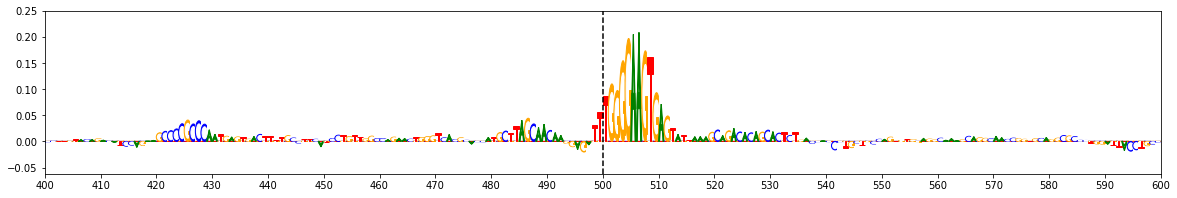

Noneffect Allele: C   ||  Explain Score: 1.7442   ||  Center / 200bp: 0.6273
Noneffect Sequence: CAAGGAGATCTGGGGAAGTG


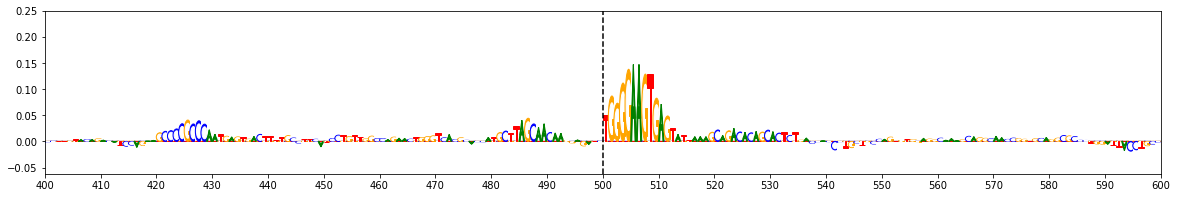

Allele Ratio : 1.2711   ||   Allele Difference : 0.4333  ||  ISM Score : 0.6763  ||  deltaSVM Score : 3.9362


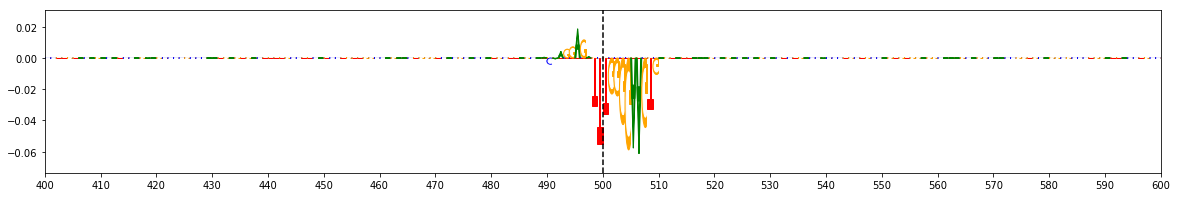


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56317818   ||    chr19 : 44856328 - 44856329   ||    Locus: 283   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.72E-94
Alzheimers_Kunkle_2019 		  7.60E-94
Alzheimers_Lambert_2013 	  1.83E-85

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6668   ||  Center / 200bp: 0.4293
Effect Sequence: ATTAGCCTCTTCCCCAACAC


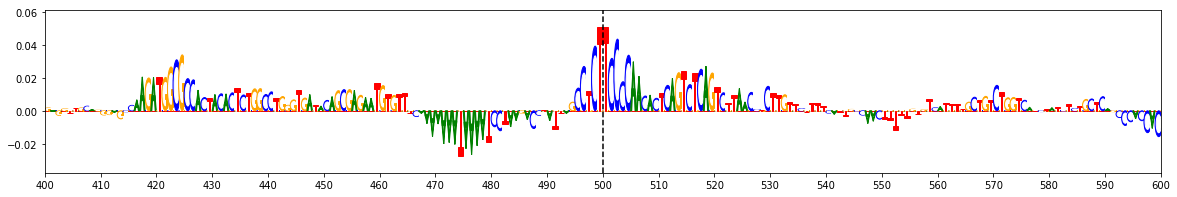

Noneffect Allele: C   ||  Explain Score: 0.338   ||  Center / 200bp: 0.2758
Noneffect Sequence: ATTAGCCTCCTCCCCAACAC


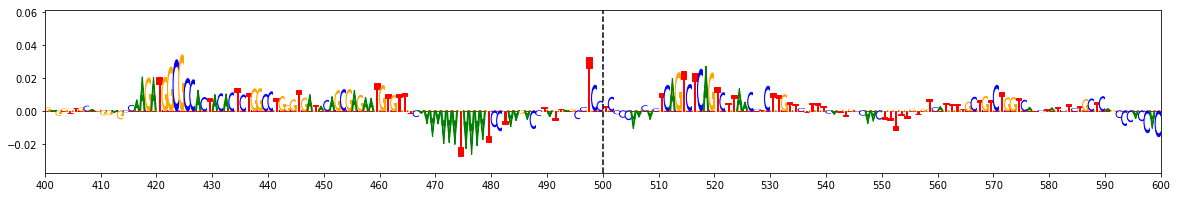

Allele Ratio : 1.9726   ||   Allele Difference : 0.3537  ||  ISM Score : 0.5518  ||  deltaSVM Score : 3.1553


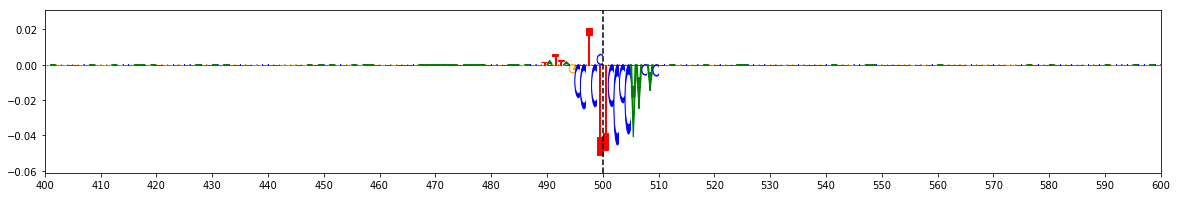


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1388597   ||    chr12 : 40224294 - 40224295   ||    Locus: 93   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.37E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.9816   ||  Center / 200bp: 0.6737
Effect Sequence: CTCACAGGGGAACAATGTTT


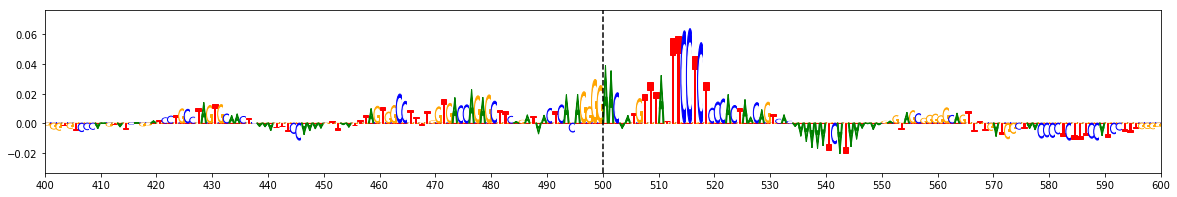

Noneffect Allele: A   ||  Explain Score: 0.8173   ||  Center / 200bp: 0.6327
Noneffect Sequence: CTCACAGGGAAACAATGTTT


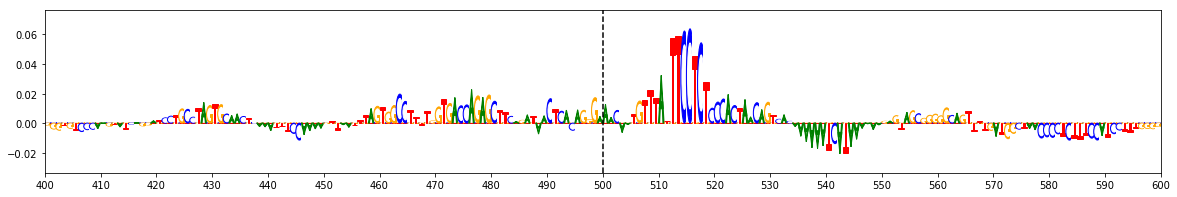

Allele Ratio : 1.2009   ||   Allele Difference : 0.1666  ||  ISM Score : 0.2628  ||  deltaSVM Score : 1.4849


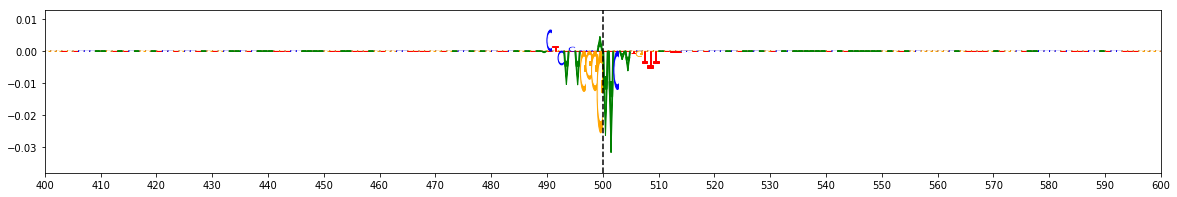


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 433   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.4669   ||  Center / 200bp: 0.4854
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


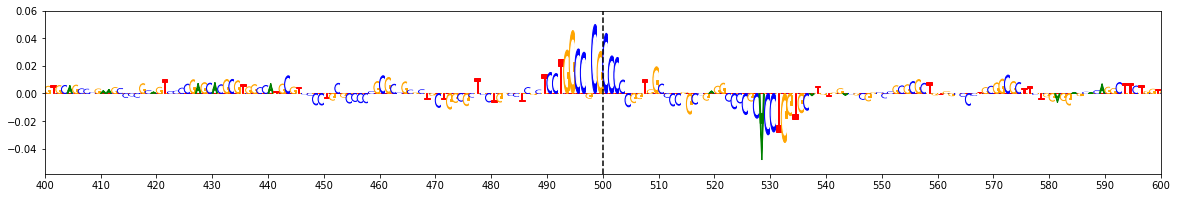

Noneffect Allele: A   ||  Explain Score: 0.2811   ||  Center / 200bp: 0.3586
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


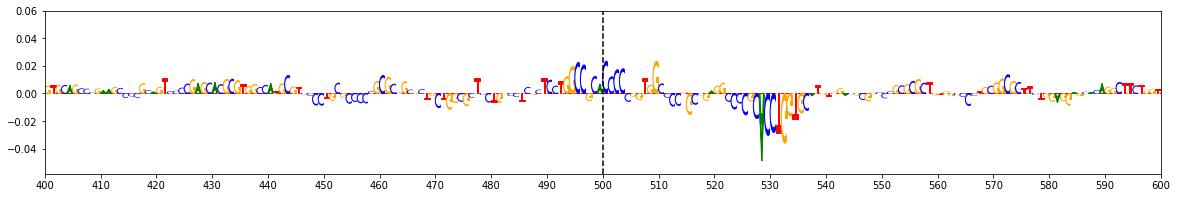

Allele Ratio : 1.6607   ||   Allele Difference : 0.1817  ||  ISM Score : 0.2922  ||  deltaSVM Score : 1.8509


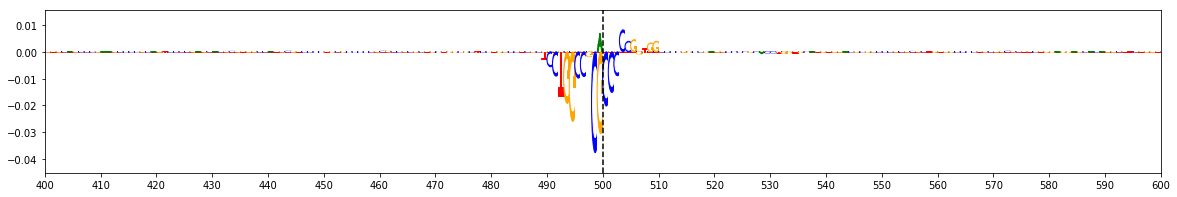


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12643198   ||    chr4 : 76242272 - 76242273   ||    Locus: 437   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  4.35E-05

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7769   ||  Center / 200bp: 0.6172
Effect Sequence: CTTGCAATAGTGAGTGAGTT


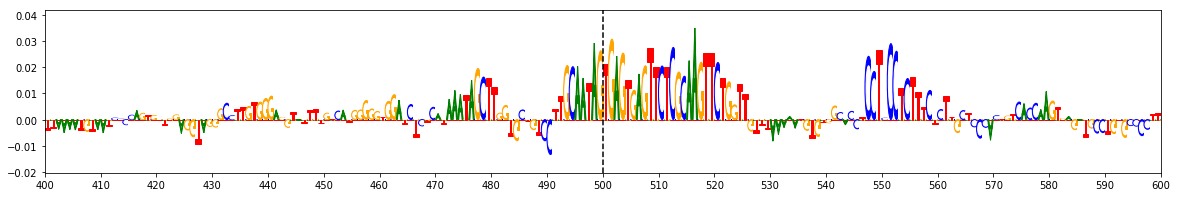

Noneffect Allele: A   ||  Explain Score: 0.5974   ||  Center / 200bp: 0.5538
Noneffect Sequence: CTTGCAATAATGAGTGAGTT


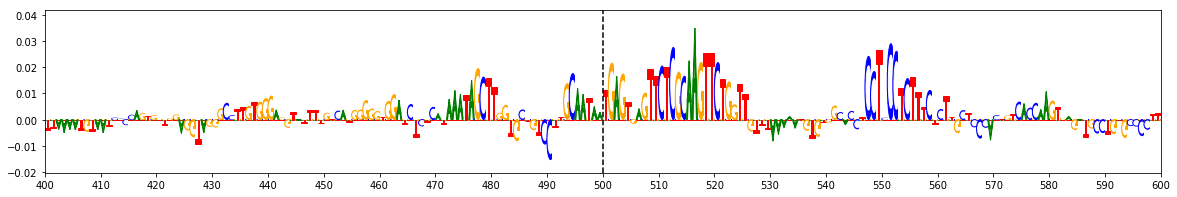

Allele Ratio : 1.3005   ||   Allele Difference : 0.1871  ||  ISM Score : 0.2902  ||  deltaSVM Score : 1.6978


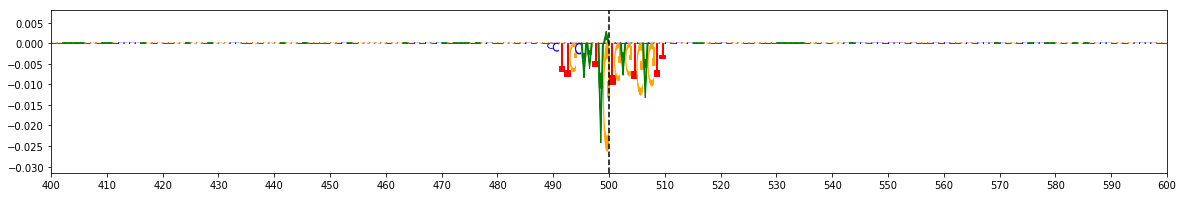


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4663100   ||    chr2 : 127120861 - 127120862   ||    Locus: 357   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.60E-12
Alzheimers_Kunkle_2019 		  6.51E-12
Alzheimers_Lambert_2013 	  7.19E-09

Coloc:  False

Effect Allele: C   ||  Explain Score: 1.4869   ||  Center / 200bp: 0.653
Effect Sequence: TCCCGTTTGCGGTTGGGGAC


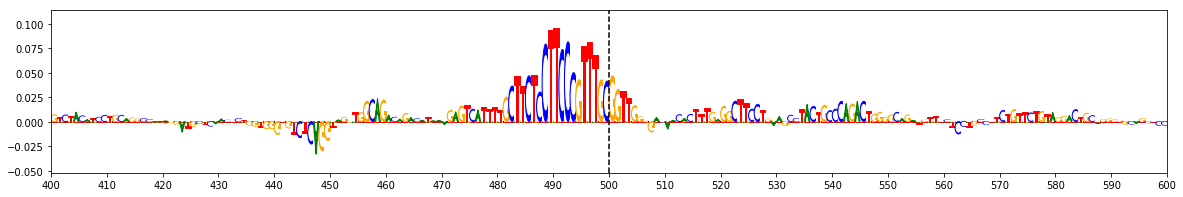

Noneffect Allele: G   ||  Explain Score: 1.2219   ||  Center / 200bp: 0.6075
Noneffect Sequence: TCCCGTTTGGGGTTGGGGAC


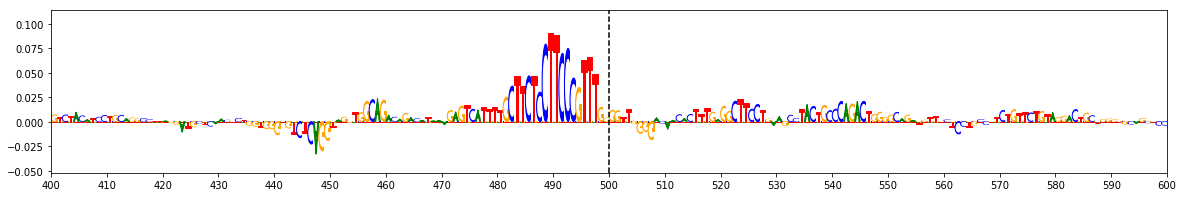

Allele Ratio : 1.2169   ||   Allele Difference : 0.2985  ||  ISM Score : 0.4662  ||  deltaSVM Score : 2.6709


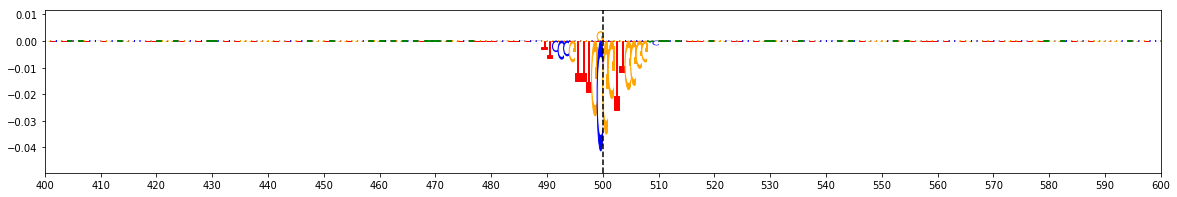


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs636341   ||    chr11 : 60251687 - 60251688   ||    Locus: 40   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.24E-13
Alzheimers_Kunkle_2019 		  4.96E-15
Alzheimers_Lambert_2013 	  1.41E-10

Coloc:  False

Effect Allele: A   ||  Explain Score: 2.4985   ||  Center / 200bp: 0.7654
Effect Sequence: TCTGCTGGGAAATTGTGAAA


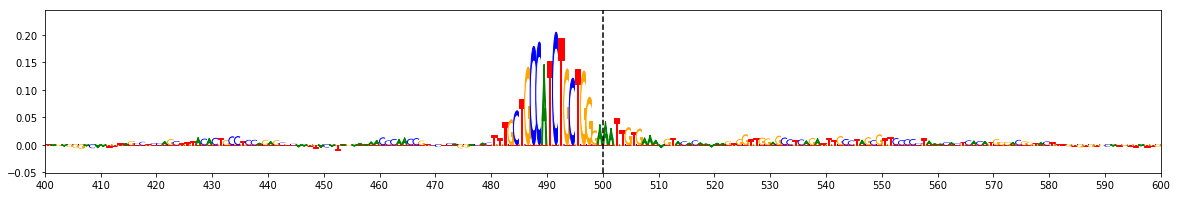

Noneffect Allele: C   ||  Explain Score: 2.4149   ||  Center / 200bp: 0.7594
Noneffect Sequence: TCTGCTGGGCAATTGTGAAA


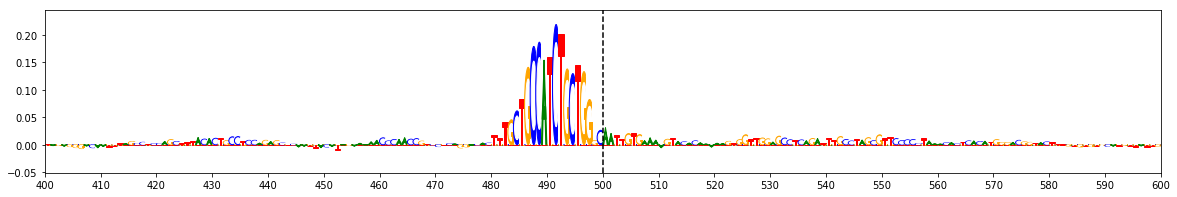

Allele Ratio : 1.0346   ||   Allele Difference : 0.0836  ||  ISM Score : 0.1275  ||  deltaSVM Score : 0.6868


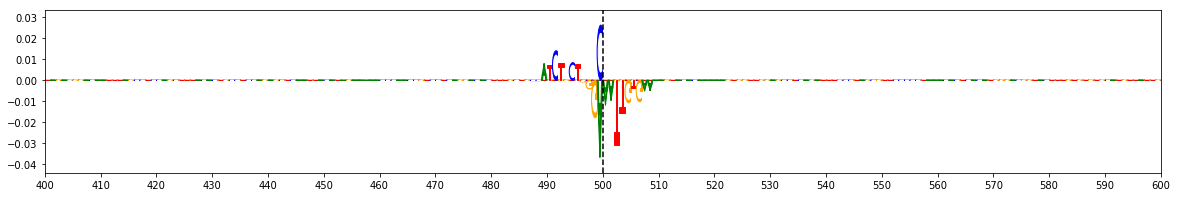


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs58522314   ||    chr19 : 44713380 - 44713381   ||    Locus: 251   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.44E-08

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.0391   ||  Center / 200bp: 0.5115
Effect Sequence: TAAAGTTCCGCCCACTGACT


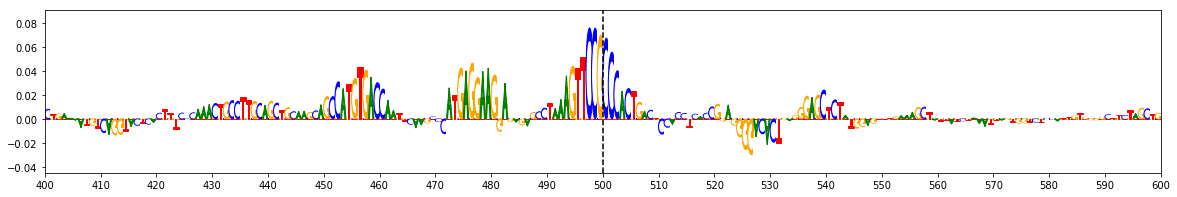

Noneffect Allele: A   ||  Explain Score: 0.6909   ||  Center / 200bp: 0.4105
Noneffect Sequence: TAAAGTTCCACCCACTGACT


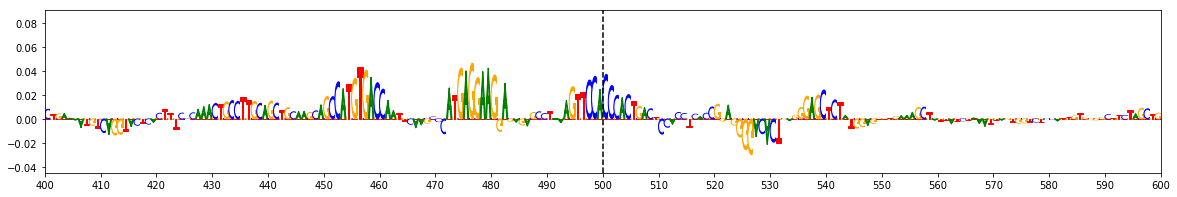

Allele Ratio : 1.504   ||   Allele Difference : 0.3518  ||  ISM Score : 0.5517  ||  deltaSVM Score : 3.1913


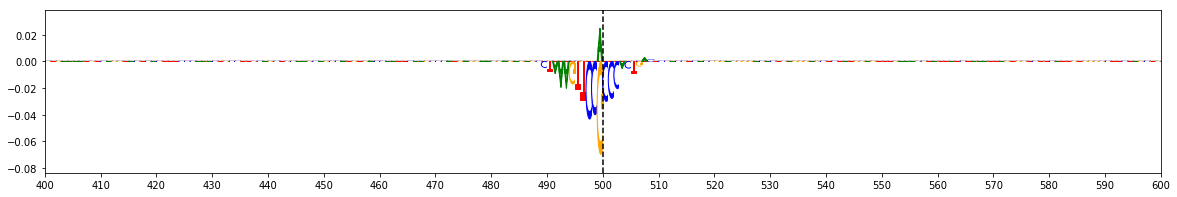


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10792832   ||    chr11 : 86156832 - 86156833   ||    Locus: 83   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.37E-18
Alzheimers_Kunkle_2019 		  7.55E-16
Alzheimers_Lambert_2013 	  6.53E-16

Coloc:  False

Effect Allele: A   ||  Explain Score: 1.6983   ||  Center / 200bp: 0.6302
Effect Sequence: AAAATGTAGAAGCAAAACAT


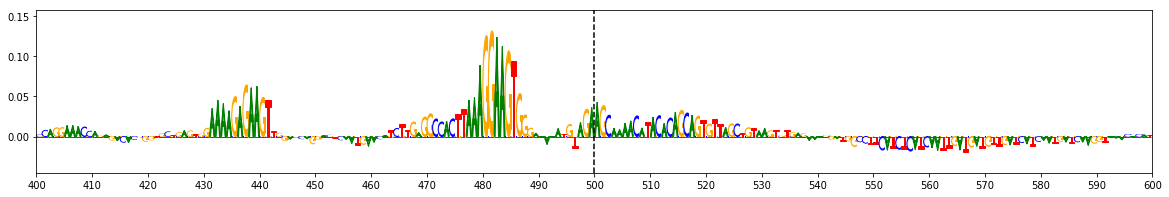

Noneffect Allele: G   ||  Explain Score: 1.4146   ||  Center / 200bp: 0.5869
Noneffect Sequence: AAAATGTAGGAGCAAAACAT


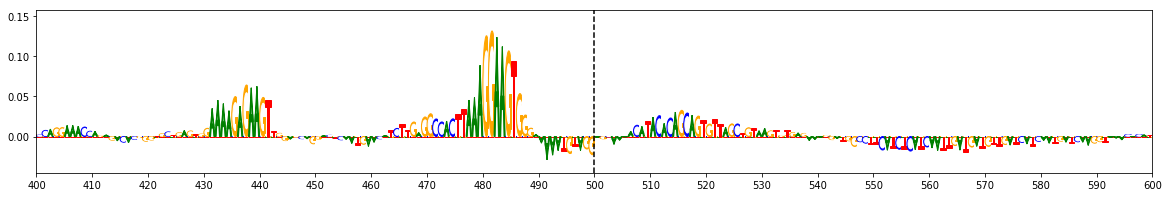

Allele Ratio : 1.2005   ||   Allele Difference : 0.4603  ||  ISM Score : 0.7204  ||  deltaSVM Score : 4.1674


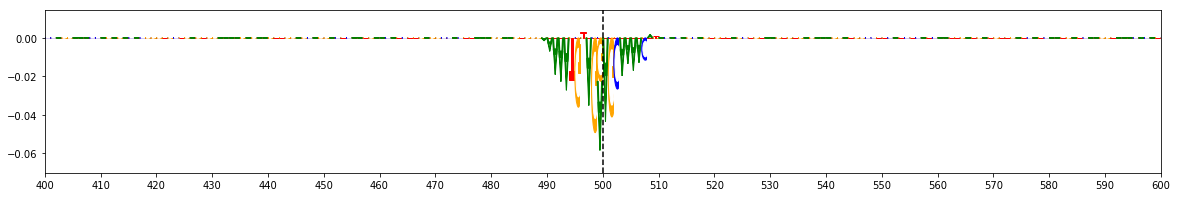


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2696633   ||    chr17 : 46192692 - 46192693   ||    Locus: 198   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  7.65E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5924   ||  Center / 200bp: 0.5328
Effect Sequence: TTCCGGGGGTTTTTTCTACC


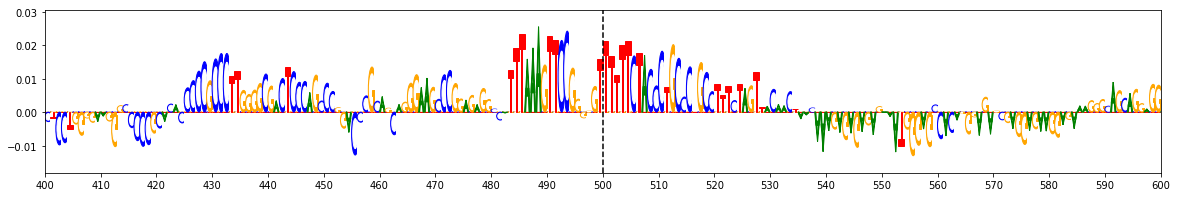

Noneffect Allele: A   ||  Explain Score: 0.4211   ||  Center / 200bp: 0.4471
Noneffect Sequence: TTCCGGGGGATTTTTCTACC


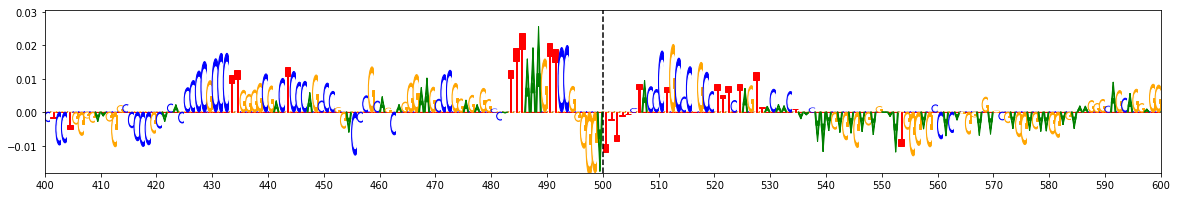

Allele Ratio : 1.4066   ||   Allele Difference : 0.2623  ||  ISM Score : 0.4115  ||  deltaSVM Score : 2.3985


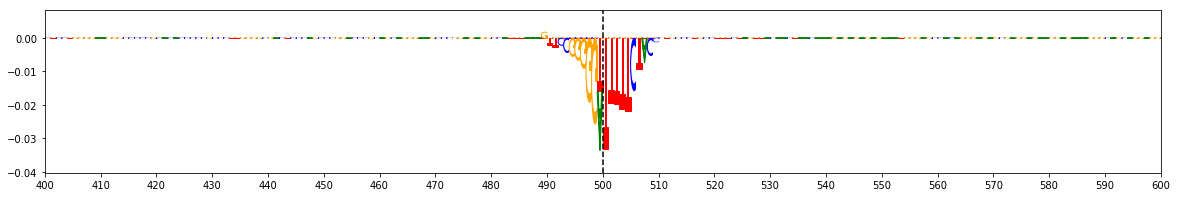


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62064641   ||    chr17 : 45411425 - 45411426   ||    Locus: 164   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  7.43E-20

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.8742   ||  Center / 200bp: 0.6858
Effect Sequence: TTCCTCCTCTGGCCCCCACC


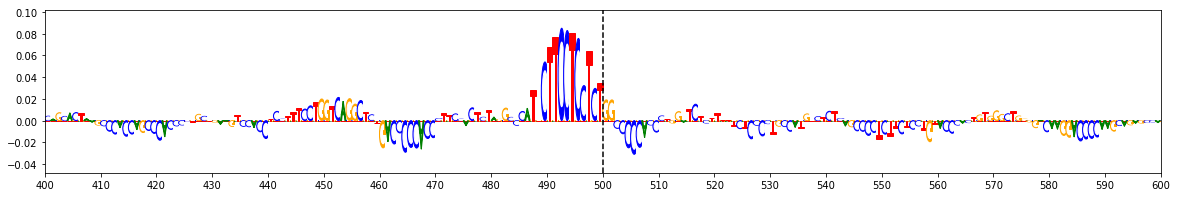

Noneffect Allele: C   ||  Explain Score: 0.808   ||  Center / 200bp: 0.6671
Noneffect Sequence: TTCCTCCTCCGGCCCCCACC


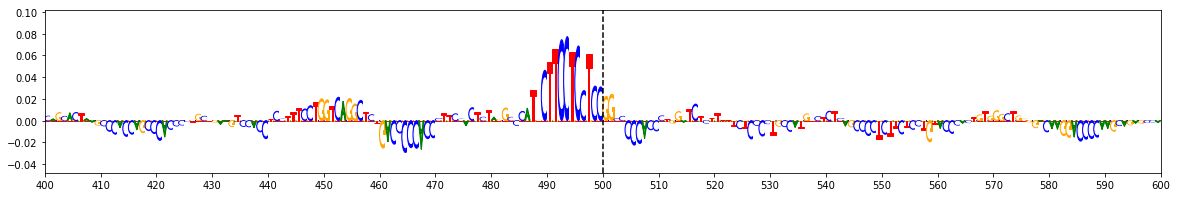

Allele Ratio : 1.0819   ||   Allele Difference : 0.0311  ||  ISM Score : 0.0602  ||  deltaSVM Score : 0.3872


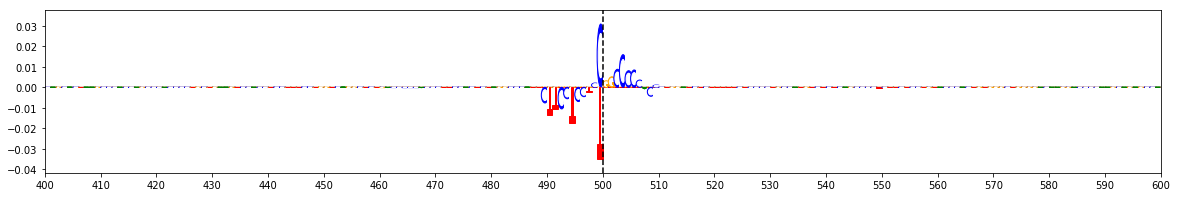


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2298914   ||    chr1 : 171741264 - 171741265   ||    Locus: 9   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.22E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.4448   ||  Center / 200bp: 0.3443
Effect Sequence: GCAAAGGCTTTCCTTTTCCC


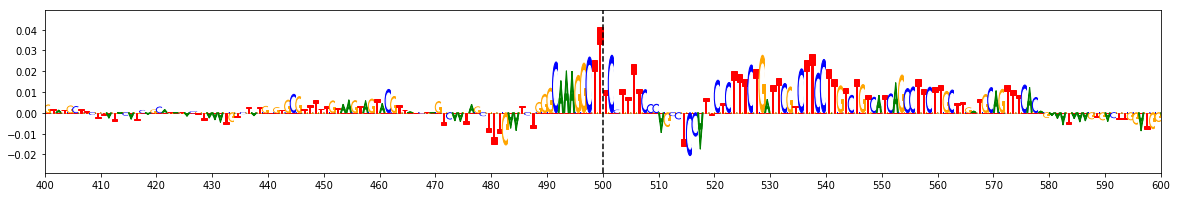

Noneffect Allele: C   ||  Explain Score: 0.2067   ||  Center / 200bp: 0.1959
Noneffect Sequence: GCAAAGGCTCTCCTTTTCCC


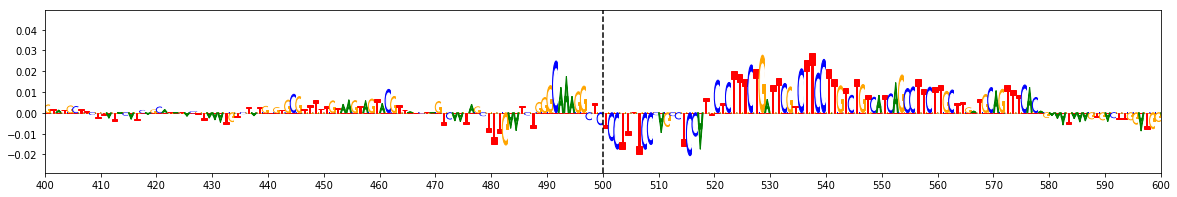

Allele Ratio : 2.1519   ||   Allele Difference : 0.3674  ||  ISM Score : 0.5674  ||  deltaSVM Score : 3.308


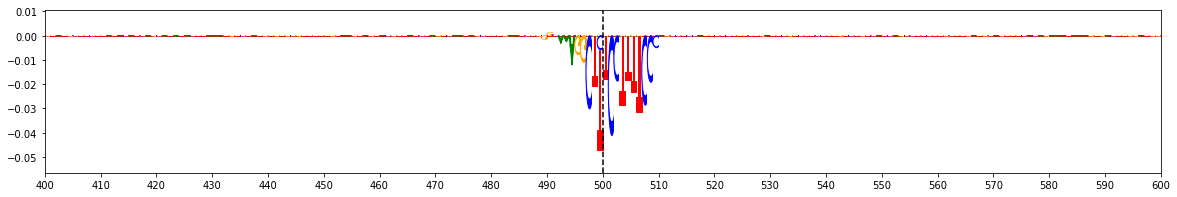


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2278890   ||    chr11 : 47378050 - 47378051   ||    Locus: 22   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  6.86E-06
Alzheimers_Kunkle_2019 		  1.38E-08

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.7526   ||  Center / 200bp: 0.5827
Effect Sequence: CTGCCACCCAAGCCCTGTCT


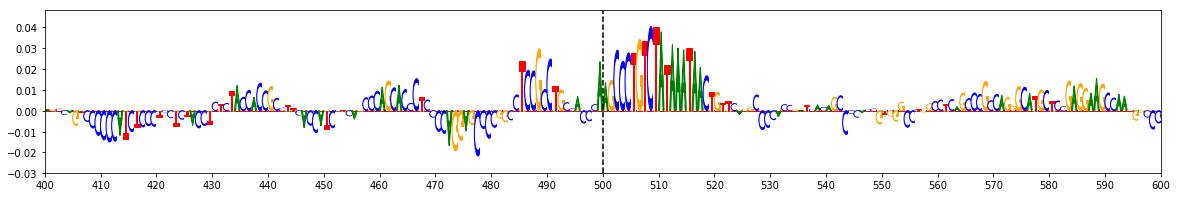

Noneffect Allele: G   ||  Explain Score: 0.5943   ||  Center / 200bp: 0.5242
Noneffect Sequence: CTGCCACCCGAGCCCTGTCT


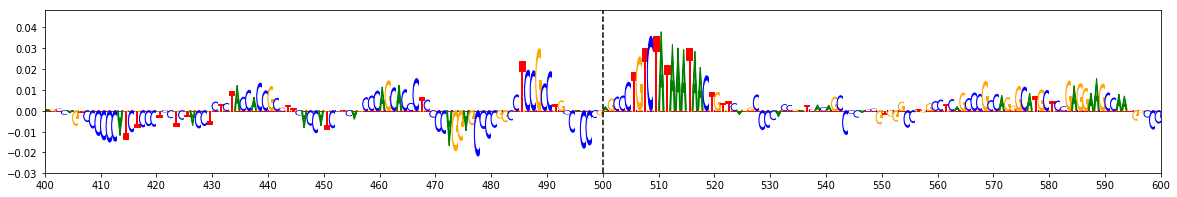

Allele Ratio : 1.2664   ||   Allele Difference : 0.1991  ||  ISM Score : 0.317  ||  deltaSVM Score : 1.8302


In [ ]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()